# 26th of September

- **This notebook/report actually consists of 8 separate notebooks:**
   - **Raw data with ObsPy and Threshold Effect**
   - **Raw data with Eqcorrscan and Threshold Effect (Appendix 1)**
   - **Preprocessed data with ObsPy and Threshold Effect**
   - **Preprocessed data with Eqcorrscan and Threshold Effect (Appendix 2)**
   - **Raw data with ObsPy and Window-size Effect**
   - **Raw data with Eqcorrscan and Window-size Effect (Appendix 3)**
   - **Preprocessed data with ObsPy and Window-size Effect**
   - **Preprocessed data with Eqcorrscan and Window-size Effect(Appendix 4)**
   

- **Warning: You may get confused about why we did not use int module on the Eqcorrscan models. Its reason is: the eqcorrscan algorithm already uses the int module. Also, we showed the Eqcorrscan as Appendix/Attempts since its detection times are given twice(caused by the source code), but the rest is correct. And, on the histograms, the blue lines are shown two times of the actual length(because of the algortihm counts twice)**

In [ ]:
from __future__ import print_function
import obspy
from obspy import read, read_inventory, read_events
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.trigger import classic_sta_lta, plot_trigger,coincidence_trigger, recursive_sta_lta, z_detect,trigger_onset
from pprint import pprint
import eqcorrscan
from eqcorrscan.utils.picker import stalta_pick

from os.path import join as opj
import sys
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO
    import operator
import functools
import pandas as pd
import re

# Preparing Catalog

In [ ]:
workdir = '/Users/korayaydogan/Downloads/SLVT'
with open(opj(workdir, 'hyp.out')) as f:
    hyp_txt = f.read()
# two new lines and a bunch of space between each recod
record_separator = '\n +\n'

hyp_split = re.split(record_separator, hyp_txt)
assert hyp_split[-1]==''
hyp_split_trim = [s for s in hyp_split if s]
# just one empty record
assert len(hyp_split_trim) == len(hyp_split) - 1

In [ ]:
# pick the first line of each metadata
hyp_meta_str_list = [s.split('\n')[0] for s in hyp_split_trim]
hyp_meta_str = '\n'.join(hyp_meta_str_list)
hyp_meta_check = pd.read_csv(StringIO(hyp_meta_str), header=None, delim_whitespace=True)


#the fallowing numbers indicate that the interval of the number of digits
#for example "2019" has 4 digits, so for this info we split as (0,5)
colspecs_hyp_meta = [(0,5),(6,8),(8,10),(11,13),(13,15),(16,21),(21,22),
                     (23,30),(31,38),(39,43),(44,48),(49,51),(52,56),
                     (72,75),(75,79),(79,80)]
hyp_meta =pd.read_fwf(StringIO(hyp_meta_str),
                      colspecs=colspecs_hyp_meta,
                      header=None)

In [ ]:
colspecs_hyp_list = [(0,5),(6,8),(8,14),(14,15),(15,17),
                  (18,20),(20,22),(23,29),(29,33),
                  (34,40),(41,45),(46,51),(52,56),
                  (57,60),(61,63),(63,68),(68,70),
                  (70,75),(75,80)]
hyp_list = [pd.read_fwf(StringIO(s),
                      colspecs=colspecs_hyp_list,
                      skiprows=3) for s in hyp_split_trim]

In [ ]:
assert len(hyp_list) == len(hyp_meta)
#merged the save and out catalogs
hyp_list_meta = [pd.concat([hyp_list[i], hyp_meta.iloc[[i]*len(hyp_list[i]),:].reset_index()], axis=1)
                 for i in range(len(hyp_list))]

hyp = pd.concat(hyp_list_meta, axis=0)

In [ ]:
hyp_slvt=hyp[hyp.STAT=='SLVT']
hyp_slvt_p=hyp_slvt[hyp_slvt.IPHAS=='IP']
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 584)
hyp_slvt_p

,STAT,SP,IPHAS,W,D,HR,MM,SECON,CODA,AMPLIT,PERI,AZIMU,VELO,AIN,AR,...,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SLVT,BZ,IP,0,NaN,16,53,48.010,NaN,NaN,NaN,NaN,NaN,131,NaN,...,9,20,16,53,40.9,L,40.963,28.308,29.2,HKR,7.0,0.10,2.2,SLVR,1
2,SLVT,BZ,IP,0,NaN,3,9,44.660,NaN,NaN,NaN,NaN,NaN,107,NaN,...,9,22,3,9,37.3,L,40.878,28.212,17.3,HKR,22.0,0.20,2.2,LDDA,1
0,SLVT,BZ,IP,0,NaN,8,39,4.570,NaN,NaN,NaN,NaN,NaN,34,NaN,...,9,22,8,38,57.2,L,40.881,28.237,1.1,HKR,16.0,0.20,2.1,LDDA,1
0,SLVT,BZ,IP,0,NaN,8,42,50.260,NaN,NaN,NaN,NaN,NaN,105,NaN,...,9,22,8,42,43.0,L,40.867,28.221,16.5,HKR,17.0,0.20,2.1,LDDA,1
0,SLVT,BZ,IP,0,NaN,12,7,17.460,NaN,NaN,NaN,NaN,NaN,93,NaN,...,9,22,12,7,10.0,L,40.857,28.211,5.5,HKR,15.0,0.20,1.9,SLVR,1
6,SLVT,BZ,IP,0,NaN,13,19,26.400,NaN,NaN,NaN,NaN,NaN,91,NaN,...,9,22,13,19,14.9,L,40.620,28.362,9.1,HKR,11.0,0.20,1.7,SLVR,1
0,SLVT,BZ,IP,0,NaN,15,30,53.560,NaN,NaN,NaN,NaN,NaN,113,NaN,...,9,22,15,30,46.1,L,40.869,28.196,20.8,HKR,15.0,0.20,2.0,SLVR,1
0,SLVT,BZ,IP,0,NaN,23,56,31.920,NaN,NaN,NaN,NaN,NaN,76,NaN,...,9,22,23,56,24.1,L,40.820,28.159,7.4,HKR,18.0,0.30,1.5,LDDA,1
14,SLVT,BZ,IP,0,NaN,6,21,58.520,NaN,NaN,NaN,NaN,NaN,94,NaN,...,9,24,6,21,48.3,L,40.863,28.705,11.0,HKR,24.0,0.20,2.2,LDDA,1
5,SLVT,ZZ,IP,0,NaN,7,30,57.299,NaN,NaN,NaN,NaN,NaN,101,NaN,...,9,24,7,30,49.8,L,40.865,28.190,14.8,HKR,27.0,0.20,3.0,LDDA,1


In [ ]:
#we picked 26th of Septembre
hyp_slvt26=hyp_slvt_p[hyp_slvt_p[2]==26]
pd.set_option('display.max_columns', 36)
pd.set_option('display.max_rows', 584)
hyp_slvt26

,STAT,SP,IPHAS,W,D,HR,MM,SECON,CODA,AMPLIT,PERI,AZIMU,VELO,AIN,AR,TRES,W.1,DIS,CAZ7,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
17,SLVT,BZ,IP,0,NaN,4,5,48.160,NaN,NaN,NaN,NaN,NaN,91,NaN,-0.22,10.0,58.8,318,59,2019,9,26,4,5,38.2,L,40.840,28.683,8.7,HKR,24.0,0.20,2.1,LDDA,1
2,SLVT,ZZ,IP,0,NaN,7,32,14.677,NaN,NaN,NaN,NaN,NaN,106,NaN,0.01,10.0,39.8,0,61,2019,9,26,7,32,7.3,L,40.872,28.208,16.6,HKR,20.0,0.10,3.6,WDDA,1
3,SLVT,BZ,IP,0,NaN,7,52,54.100,NaN,NaN,NaN,NaN,NaN,102,NaN,-0.02,10.0,38.7,2,62,2019,9,26,7,52,47.0,L,40.881,28.192,14.9,HKR,19.0,0.20,2.5,SLVR,1
3,SLVT,ZZ,IP,0,NaN,8,27,16.187,NaN,NaN,NaN,NaN,NaN,76,NaN,0.07,10.0,40.5,3,63,2019,9,26,8,27,8.8,L,40.865,28.188,7.5,HKR,17.0,0.10,2.3,SLVR,1
3,SLVT,BZ,IP,0,NaN,9,0,24.380,NaN,NaN,NaN,NaN,NaN,102,NaN,-0.02,10.0,41.4,359,64,2019,9,26,9,0,16.9,L,40.857,28.216,13.1,HKR,24.0,0.10,2.9,LDDA,1
5,SLVT,BZ,IP,0,NaN,10,59,32.667,NaN,NaN,NaN,NaN,NaN,103,NaN,0.07,10.0,40.0,2,65,2019,9,26,10,59,25.3,L,40.870,28.197,13.4,HKR,36.0,0.12,5.8,LDDA,1
4,SLVT,BZ,IP,4,NaN,11,4,44.880,NaN,NaN,NaN,NaN,NaN,115,NaN,-1.49,0.0,37.5,3,66,2019,9,26,11,4,39.1,L,40.893,28.190,21.4,HKR,16.0,0.20,3.0,SLVR,1
5,SLVT,ZZ,IP,0,NaN,11,4,46.737,NaN,NaN,NaN,NaN,NaN,115,NaN,0.36,10.0,37.5,3,66,2019,9,26,11,4,39.1,L,40.893,28.190,21.4,HKR,16.0,0.20,3.0,SLVR,1
3,SLVT,BZ,IP,0,NaN,11,9,7.488,NaN,NaN,NaN,NaN,NaN,76,NaN,0.05,10.0,42.3,353,67,2019,9,26,11,8,60.0,L,40.851,28.270,8.1,HKR,24.0,0.20,3.1,SLVR,1
3,SLVT,BZ,IP,0,NaN,11,11,42.408,NaN,NaN,NaN,NaN,NaN,69,NaN,-0.27,10.0,42.6,354,68,2019,9,26,11,11,35.1,L,40.848,28.260,4.1,HKR,17.0,0.20,3.3,LDDA,1


Obtaining the utc date times

In [ ]:
year=hyp_slvt26[0].to_numpy(dtype='int64')
month=hyp_slvt26[1].to_numpy(dtype='int64')
day=hyp_slvt26[2].to_numpy(dtype='int64')
hour=hyp_slvt26['HR'].to_numpy(dtype='int64')
minute=hyp_slvt26['MM'].to_numpy(dtype='int64')
second=hyp_slvt26['SECON'].to_numpy(dtype='int64')
microsec=round((hyp_slvt26['SECON'] % 1) * 1e6).to_numpy(dtype='int64')

num_of_event=hyp_slvt26.shape[0]

utc_time26=[]
for my_event_index in range(num_of_event):

    myevent_utc1 = obspy.UTCDateTime(year = year[my_event_index],
                                        month = month[my_event_index],
                                        day = day[my_event_index],
                                        hour = hour[my_event_index],
                                        minute = minute[my_event_index] ,
                                        second = second[my_event_index] ,
                                        microsecond = microsec[my_event_index]
                                    )
    utc_time26.append(myevent_utc1)

In [ ]:
utc_time26

[2019-09-26T04:05:48.160000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T07:52:54.100000Z,
 2019-09-26T08:27:16.187000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:04:44.880000Z,
 2019-09-26T11:04:46.737000Z,
 2019-09-26T11:09:07.488000Z,
 2019-09-26T11:11:42.408000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:14:32.438000Z,
 2019-09-26T11:17:02.968000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-26T11:21:24.720000Z,
 2019-09-26T11:23:02.880000Z,
 2019-09-26T11:26:10.908000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T11:28:54.832000Z,
 2019-09-26T11:29:22.208000Z,
 2019-09-26T11:31:59.370000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T11:35:56.017000Z,
 2019-09-26T11:38:24.648000Z,
 2019-09-26T11:43:02.870000Z,
 2019-09-26T11:43:04.108000Z,
 2019-09-26T11:45:41.920000Z,
 2019-09-26T11:51:34.030000Z,
 2019-09-26T11:53:52.720000Z,
 2019-09-26T11:53:53.957000Z,
 2019-09-26T11:58:52.198000Z,
 2019-09-26T12:00:33.600000Z,
 2019-09-2

In [ ]:
magnitudes26=hyp_slvt26[13].to_numpy() #obtaining magnitudes for 26th of september
magnitudes26

array([ 2.1,  3.6,  2.5,  2.3,  2.9,  5.8,  3. ,  3. ,  3.1,  3.3,  2.3,
        2.7,  2.6,  1.9,  2.9,  2.1,  2. ,  2.2,  4.1,  2.5,  2.8,  3. ,
        3.2,  2.1,  1.4,  2.6,  2.6,  2. ,  2.1,  2. ,  2. ,  1.9,  2.2,
        2.2,  2.7,  1.9,  3.4,  3.7,  3.7,  1.6,  1.6,  2.1,  3.5,  1.7,
        1.4,  2.2,  2.1,  3. ,  1.5,  1.6,  2.8,  1.2,  1.1,  3.2,  2.7,
        2.6,  2.1,  1.8,  1.7,  1.4,  1.3,  1.5,  1.2,  1.4,  1.3,  1.5,
        1.4,  1.4,  1.4,  1.6,  1.3,  1.6,  3. ,  1.2,  1.8,  1.8,  1.3,
        1.1,  1. ,  1.8,  1.4,  2.3,  1.3,  1.9,  1.3,  1.8,  1.1,  1.2,
        1.3,  1.1,  1.9,  1.6,  1.9,  1.2,  1.1,  2. ,  1.4,  0.6,  1.8,
        1. ,  1.1,  1.2,  1.2,  1.1,  2.2,  2. ,  1.6,  1.6,  1.5,  3.5,
        1.8,  1. ,  2. ,  1.1,  1.1,  3.9,  1.2,  1.5,  1.7,  1.3,  1. ,
        1.5,  1.2,  1.2,  1.4,  1.1,  1.8,  1.7,  1. ,  1.7,  1.6,  2.1,
        1.4,  2.2,  1.4,  1.7,  1.5,  1.9,  1.4,  1.3,  1.3,  1.2,  1.2,
        2.2,  1.5,  1.9])

# Reading the data

In [ ]:
st= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ')

In [ ]:
tr1=st[0]
tr2=st[1]#obtaining traces
tr3=st[2]

# With ObsPy (Nothing Applied)

# The Effect of the Threshold

## 0.5-0.25

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 0.5, 0.25)

In [ ]:
on_of.shape
#the first component of the matrix is the number of the detection by the algorithm

(48, 2)

In [ ]:
onof=on_of.shape[0]

- **There is a mathematical ratio; the x axis is the number of samples which is 8640009 and it is proportional to 1 day. Then, we wrote a code which lead to give us the location of the detection (in seconds). And the for loop is used dor the detection times.**

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
detection_times
#the dates of the detections by the algorithm (the locations of the lines that are shown in the previous presentation)

[2019-09-26T00:00:59.998993Z,
 2019-09-26T00:44:02.928694Z,
 2019-09-26T00:44:27.008691Z,
 2019-09-26T07:33:21.315852Z,
 2019-09-26T07:35:28.655837Z,
 2019-09-26T11:01:46.914404Z,
 2019-09-26T11:01:58.094403Z,
 2019-09-26T11:03:46.594390Z,
 2019-09-26T11:03:57.294389Z,
 2019-09-26T11:06:55.044369Z,
 2019-09-26T11:07:19.914366Z,
 2019-09-26T11:08:08.274360Z,
 2019-09-26T11:09:37.634350Z,
 2019-09-26T11:10:42.154342Z,
 2019-09-26T11:11:17.954338Z,
 2019-09-26T11:11:24.914337Z,
 2019-09-26T11:11:34.164336Z,
 2019-09-26T11:11:50.404334Z,
 2019-09-26T11:12:15.624332Z,
 2019-09-26T11:12:26.534330Z,
 2019-09-26T11:12:38.554329Z,
 2019-09-26T11:12:48.074328Z,
 2019-09-26T11:12:59.614326Z,
 2019-09-26T11:13:06.434326Z,
 2019-09-26T11:13:20.214324Z,
 2019-09-26T11:13:27.024323Z,
 2019-09-26T11:13:33.934322Z,
 2019-09-26T11:14:02.004319Z,
 2019-09-26T11:14:16.704318Z,
 2019-09-26T11:14:29.094316Z,
 2019-09-26T11:14:38.214315Z,
 2019-09-26T11:14:57.894313Z,
 2019-09-26T11:15:13.264311Z,
 2019-09-2

In [ ]:
num_detect_tim=len(detection_times)
num_detect_tim
#the number of detections by the algorithm

48

In [ ]:
cat_time26=len(utc_time26)
cat_time26
#the number of the dates when the earthquake occurred in the catalog

146

- **The fallowing for loop is used for comparing the dates with the catalog. It is wrtitten with three seconds tolerance. If it exceeds the date more than three seconds, the loop will not count as a correct date.**

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count
#the number of the correct earthquakes which is detected by the algorithm also there is three seconds tolerance!

2

In [ ]:
correct_det_times
#the dates of correct earthquakes.

[2019-09-26T11:13:31.340000Z, 2019-09-26T12:17:17.397000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])
#that for loop is written for; if the detection time is the same as in the catalog, find the magnitude from the catalog
#and bring togeher them

In [ ]:
correct_det_mag
#magnitudes

[2.2999999999999998, 3.7000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

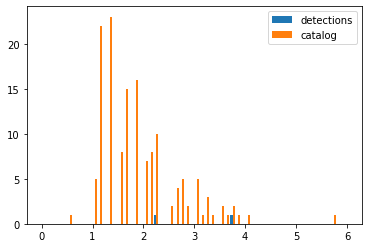

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2- 0.5

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 2, 0.5)

In [ ]:
on_of.shape

(19, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
cat_time26=len(utc_time26)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

4

In [ ]:
correct_det_times

[2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
# bu yapıyor lta sta deki magnitude dakileri
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

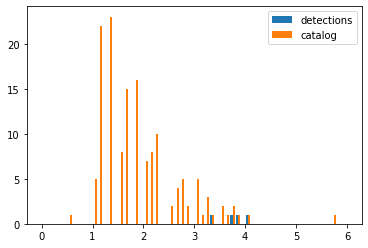

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2.75 - 1.75

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(24, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
cat_time26=len(utc_time26)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

6

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

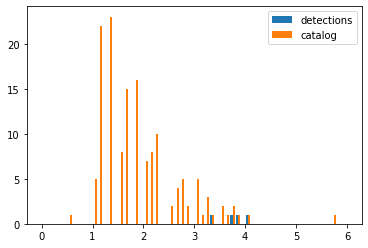

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 5-2

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 5, 2)

In [ ]:
on_of.shape

(14, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
cat_time26=len(utc_time26)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

4

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 4.0999999999999996, 3.7000000000000002, 3.5]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

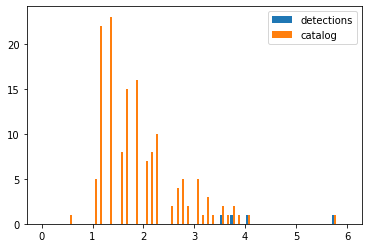

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 6-4

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data,int(2*df),int(df*60))
on_of = trigger_onset(cft, 6, 4)

In [ ]:
on_of.shape

(14, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
cat_time26=len(utc_time26)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

4

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 4.0999999999999996, 3.7000000000000002, 3.5]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

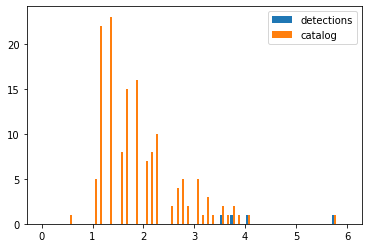

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 8-6

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 8, 6)

In [ ]:
on_of.shape

(16, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
cat_time26=len(utc_time26)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

3

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 4.0999999999999996, 3.7000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

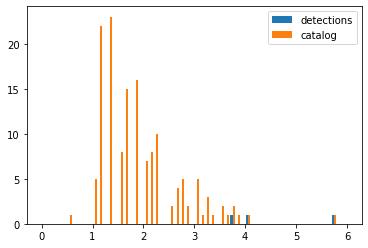

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 10 - 8

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 10, 8)

In [ ]:
on_of.shape

(13, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
cat_time26=len(utc_time26)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

3

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 4.0999999999999996, 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

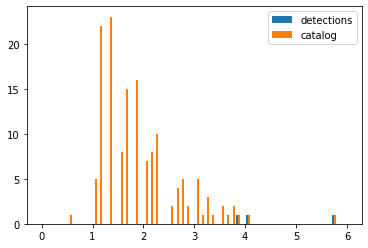

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher threshold value is changing. "thres" array consists of the threshold values, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm and compared with the catalog, do not forget, there is three seconds tolerance.**

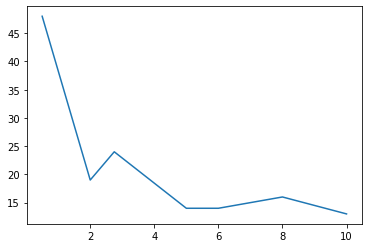

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det = np.array([48,19,24,14,14,16,13])
plt.plot(thres, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

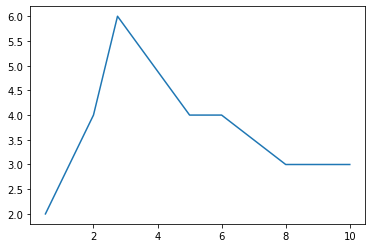

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det_cor = np.array([2,4,6,4,4,3,3])
plt.plot(thres, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# APPENDIX 1 :  With EqCorrscan (Nothing Applied)

# The Effect of the Threshold

## 0.5-0.25

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=0.5, trig_off=0.25)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/4669db72-9d40-458d-867c-ae950689c3ce")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 40, 189919))
	          ---------
	      comments: 1 Elements
	         picks: 305 Elements
	       origins: 1 Elements

In [ ]:
len(events)

15

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/7e2f138a-5b33-4860-8ef9-baab11094052"), time=UTCDateTime(2019, 9, 26, 0, 0, 59, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/32d52a1e-63b2-4cea-99e2-b1583baf8265"), time=UTCDateTime(2019, 9, 26, 0, 11, 50, 229000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/781eddd6-d077-4312-8233-6fd5b4f3177f"), time=UTCDateTime(2019, 9, 26, 0, 12, 55, 539000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a808a261-5eba-41b3-a0f7-29a3735792b5"), time=UTCDateTime(2019, 9, 26, 0, 19, 21, 99000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pi

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:00:59.989000Z,
 2019-09-26T00:11:50.229000Z,
 2019-09-26T00:12:55.539000Z,
 2019-09-26T00:19:21.099000Z,
 2019-09-26T00:19:43.149000Z,
 2019-09-26T00:26:09.799000Z,
 2019-09-26T00:40:59.719000Z,
 2019-09-26T00:44:02.609000Z,
 2019-09-26T00:44:26.759000Z,
 2019-09-26T00:45:26.259000Z,
 2019-09-26T01:03:06.839000Z,
 2019-09-26T07:32:55.149000Z,
 2019-09-26T07:33:48.269000Z,
 2019-09-26T07:33:54.829000Z,
 2019-09-26T11:00:29.869000Z,
 2019-09-26T11:00:38.189000Z,
 2019-09-26T11:00:48.799000Z,
 2019-09-26T11:00:56.359000Z,
 2019-09-26T11:00:59.119000Z,
 2019-09-26T11:01:09.239000Z,
 2019-09-26T11:01:46.369000Z,
 2019-09-26T11:01:55.989000Z,
 2019-09-26T11:02:33.819000Z,
 2019-09-26T11:02:43.009000Z,
 2019-09-26T11:02:50.439000Z,
 2019-09-26T11:03:10.409000Z,
 2019-09-26T11:03:17.329000Z,
 2019-09-26T11:03:22.419000Z,
 2019-09-26T11:03:39.379000Z,
 2019-09-26T11:04:14.149000Z,
 2019-09-26T11:04:23.229000Z,
 2019-09-26T11:04:33.159000Z,
 2019-09-26T11:04:50.869000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)

In [ ]:
num_detect_tim = detect_tim.shape[0]
num_detect_tim

305

In [ ]:
cat_time26=len(utc_time26)
cat_time26

146

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

9

In [ ]:
correct_det_times

[2019-09-26T11:09:07.488000Z,
 2019-09-26T11:11:42.408000Z,
 2019-09-26T11:17:02.968000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-26T11:11:42.408000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:14:32.438000Z,
 2019-09-26T11:17:02.968000Z,
 2019-09-26T11:17:02.968000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.1000000000000001,
 3.2999999999999998,
 2.6000000000000001,
 2.8999999999999999,
 3.2999999999999998,
 2.2999999999999998,
 2.7000000000000002,
 2.6000000000000001,
 2.6000000000000001]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

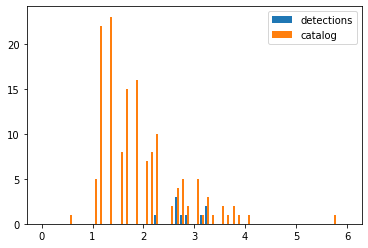

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2- 0.5

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=2, trig_off=0.5)
events

Event:	2019-09-26T00:11:13.399000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/30c65fdd-5e59-4747-a4e8-c3bd9455f446")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 42, 27118))
	          ---------
	      comments: 1 Elements
	         picks: 146 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/423832e2-cb19-4ca8-a95c-ffa10e60e063"), time=UTCDateTime(2019, 9, 26, 0, 11, 54, 869000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/c0f5c47a-e02a-4b2a-b010-071df84027d0"), time=UTCDateTime(2019, 9, 26, 0, 13, 41, 619000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/15c13117-74d8-4f33-a851-a45c4637e2ea"), time=UTCDateTime(2019, 9, 26, 0, 37, 48, 419000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/7e12382e-a17f-4c26-abf1-5d3dfcc3a95a"), time=UTCDateTime(2019, 9, 26, 0, 40, 34, 629000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 



In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:11:54.869000Z,
 2019-09-26T00:13:41.619000Z,
 2019-09-26T00:37:48.419000Z,
 2019-09-26T00:40:34.629000Z,
 2019-09-26T00:41:08.679000Z,
 2019-09-26T00:41:47.199000Z,
 2019-09-26T00:43:45.059000Z,
 2019-09-26T00:44:06.439000Z,
 2019-09-26T00:49:39.119000Z,
 2019-09-26T00:54:53.069000Z,
 2019-09-26T00:58:31.609000Z,
 2019-09-26T01:01:11.699000Z,
 2019-09-26T07:32:15.959000Z,
 2019-09-26T09:00:30.509000Z,
 2019-09-26T10:59:33.009000Z,
 2019-09-26T11:03:44.749000Z,
 2019-09-26T11:06:09.299000Z,
 2019-09-26T11:06:54.439000Z,
 2019-09-26T11:07:19.709000Z,
 2019-09-26T11:09:37.169000Z,
 2019-09-26T11:10:07.699000Z,
 2019-09-26T11:10:42.349000Z,
 2019-09-26T11:11:18.569000Z,
 2019-09-26T11:11:25.589000Z,
 2019-09-26T11:11:50.719000Z,
 2019-09-26T11:12:08.519000Z,
 2019-09-26T11:12:16.339000Z,
 2019-09-26T11:12:27.209000Z,
 2019-09-26T11:13:34.449000Z,
 2019-09-26T11:13:39.939000Z,
 2019-09-26T11:13:51.119000Z,
 2019-09-26T11:14:58.399000Z,
 2019-09-26T11:15:18.219000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)

In [ ]:
num_detect_tim = detect_tim.shape[0]
num_detect_tim

146

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

16

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:17:02.968000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])
#that for loop is written for; if the detection time is the same as in the catalog, find the magnitude from the catalog
#and bring togeher them

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 2.6000000000000001,
 2.8999999999999999,
 4.0999999999999996,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

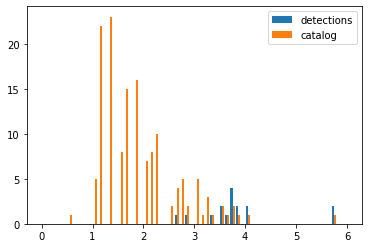

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2.75 - 1.75

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:44:08.709000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/b2e6d3a7-9ed2-4439-a82c-7041411a33b8")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 43, 249703))
	          ---------
	      comments: 1 Elements
	         picks: 91 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/bfb69663-e1ff-457d-a7c4-1703fbea872a"), time=UTCDateTime(2019, 9, 26, 0, 44, 9, 709000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4bd52e3f-ed97-4f0b-bfa4-f512c89dee3b"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 279000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/9fa2e721-e5e4-4f4d-9c2a-9a7790fa3cbe"), time=UTCDateTime(2019, 9, 26, 7, 32, 38, 819000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4d6cf1a3-c0e2-432f-95a2-b061c3558c4e"), time=UTCDateTime(2019, 9, 26, 7, 32, 42, 719000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

P

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:44:09.709000Z,
 2019-09-26T07:32:20.279000Z,
 2019-09-26T07:32:38.819000Z,
 2019-09-26T07:32:42.719000Z,
 2019-09-26T09:00:31.229000Z,
 2019-09-26T10:59:33.029000Z,
 2019-09-26T11:00:01.339000Z,
 2019-09-26T11:03:58.139000Z,
 2019-09-26T11:06:54.659000Z,
 2019-09-26T11:07:20.039000Z,
 2019-09-26T11:09:37.679000Z,
 2019-09-26T11:10:42.839000Z,
 2019-09-26T11:11:51.129000Z,
 2019-09-26T11:12:27.599000Z,
 2019-09-26T11:13:34.799000Z,
 2019-09-26T11:14:58.789000Z,
 2019-09-26T11:15:18.649000Z,
 2019-09-26T11:15:29.469000Z,
 2019-09-26T11:15:43.329000Z,
 2019-09-26T11:15:53.869000Z,
 2019-09-26T11:16:03.339000Z,
 2019-09-26T11:16:24.309000Z,
 2019-09-26T11:16:36.049000Z,
 2019-09-26T11:20:08.869000Z,
 2019-09-26T11:26:45.199000Z,
 2019-09-26T11:29:33.389000Z,
 2019-09-26T11:32:06.299000Z,
 2019-09-26T11:34:16.949000Z,
 2019-09-26T12:15:14.699000Z,
 2019-09-26T12:17:18.689000Z,
 2019-09-26T12:17:51.539000Z,
 2019-09-26T12:26:19.669000Z,
 2019-09-26T12:59:13.639000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

91

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

14

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 1.8999999999999999,
 4.0999999999999996,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

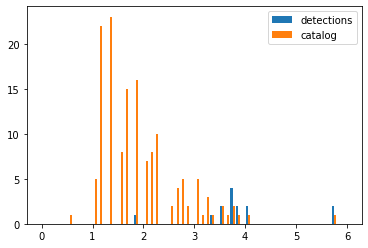

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 5-2

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=5, trig_off=2)
events

Event:	2019-09-26T07:32:19.329000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/b19640ed-eab1-4b5a-b375-191580903d3c")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 44, 348496))
	          ---------
	      comments: 1 Elements
	         picks: 39 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/6c1cd6b7-ceb0-4c5b-8fb2-d8c250cd2f5e"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 339000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/66ce4409-5c22-4156-9e83-b41f86a8b63d"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 59000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/d45840fb-e1fd-4f5f-9874-7ad18a58d785"), time=UTCDateTime(2019, 9, 26, 11, 20, 9, 429000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a0027451-20e8-4a27-9b0f-a09bc388b123"), time=UTCDateTime(2019, 9, 26, 11, 26, 45, 529000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 


In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.339000Z,
 2019-09-26T10:59:33.059000Z,
 2019-09-26T11:20:09.429000Z,
 2019-09-26T11:26:45.529000Z,
 2019-09-26T11:34:17.339000Z,
 2019-09-26T12:15:19.509000Z,
 2019-09-26T12:17:23.509000Z,
 2019-09-26T12:26:20.189000Z,
 2019-09-26T12:59:13.669000Z,
 2019-09-26T13:33:57.999000Z,
 2019-09-26T13:44:51.639000Z,
 2019-09-26T13:57:15.279000Z,
 2019-09-26T14:02:11.479000Z,
 2019-09-26T14:08:07.549000Z,
 2019-09-26T15:39:36.399000Z,
 2019-09-26T20:02:49.989000Z,
 2019-09-26T20:20:27.679000Z,
 2019-09-26T07:32:20.329000Z,
 2019-09-26T07:32:32.049000Z,
 2019-09-26T09:00:31.019000Z,
 2019-09-26T10:59:33.189000Z,
 2019-09-26T11:15:05.129000Z,
 2019-09-26T11:20:08.739000Z,
 2019-09-26T11:26:45.769000Z,
 2019-09-26T11:32:05.729000Z,
 2019-09-26T11:34:16.769000Z,
 2019-09-26T12:15:19.419000Z,
 2019-09-26T12:17:23.269000Z,
 2019-09-26T12:17:38.629000Z,
 2019-09-26T12:26:20.779000Z,
 2019-09-26T12:59:13.619000Z,
 2019-09-26T13:33:57.499000Z,
 2019-09-26T13:44:51.519000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

39

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

9

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.5]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

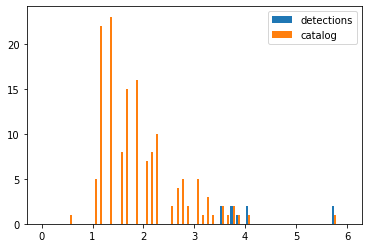

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 6-4

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=6, trig_off=4)
events

Event:	2019-09-26T07:32:19.329000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/e911c79d-da71-4ddc-911c-550734db173c")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 45, 221414))
	          ---------
	      comments: 1 Elements
	         picks: 37 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/ac120cae-18bb-4092-8fa0-8917ff0d6506"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 349000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/c96922aa-2be6-493e-88a9-6f4a59d35ec9"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 69000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/cdaf73ad-7c34-4a47-9ff4-5db6e862eaaf"), time=UTCDateTime(2019, 9, 26, 11, 20, 10, 369000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/87d4daf6-1076-46f7-94b9-976b93281a8c"), time=UTCDateTime(2019, 9, 26, 11, 26, 45, 549000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.349000Z,
 2019-09-26T10:59:33.069000Z,
 2019-09-26T11:20:10.369000Z,
 2019-09-26T11:26:45.549000Z,
 2019-09-26T11:34:18.229000Z,
 2019-09-26T12:15:19.599000Z,
 2019-09-26T12:17:23.549000Z,
 2019-09-26T12:26:20.239000Z,
 2019-09-26T12:26:25.379000Z,
 2019-09-26T12:59:13.679000Z,
 2019-09-26T13:33:58.429000Z,
 2019-09-26T13:44:51.869000Z,
 2019-09-26T13:57:15.299000Z,
 2019-09-26T15:39:36.499000Z,
 2019-09-26T20:02:50.089000Z,
 2019-09-26T20:02:54.709000Z,
 2019-09-26T20:20:27.729000Z,
 2019-09-26T07:32:20.329000Z,
 2019-09-26T10:59:33.209000Z,
 2019-09-26T11:20:08.969000Z,
 2019-09-26T11:26:45.909000Z,
 2019-09-26T11:32:09.219000Z,
 2019-09-26T11:34:16.779000Z,
 2019-09-26T12:15:19.439000Z,
 2019-09-26T12:17:23.289000Z,
 2019-09-26T12:26:21.079000Z,
 2019-09-26T12:26:25.309000Z,
 2019-09-26T12:59:13.629000Z,
 2019-09-26T13:33:57.509000Z,
 2019-09-26T13:44:51.529000Z,
 2019-09-26T13:57:14.749000Z,
 2019-09-26T14:02:09.939000Z,
 2019-09-26T15:39:35.999000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

37

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

9

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

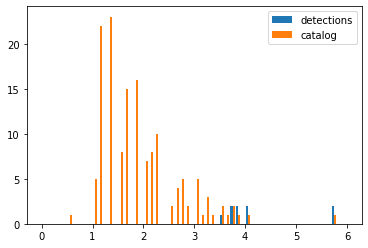

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 8-6

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=8, trig_off=6)
events

Event:	2019-09-26T07:32:19.339000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/9a3c68e6-e2ba-4d5e-86e6-62c861d19369")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 46, 79079))
	          ---------
	      comments: 1 Elements
	         picks: 40 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/7c94636c-56e6-40b7-ba41-124a3496cc0c"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 369000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/30d0ce90-697d-4734-9fb0-e3cf584c139f"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 89000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/08999145-f86f-453b-9dd0-bd4d1936a318"), time=UTCDateTime(2019, 9, 26, 11, 26, 45, 609000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/0e94b533-7307-43cc-b01e-c57a3614ddf6"), time=UTCDateTime(2019, 9, 26, 11, 26, 50, 749000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.369000Z,
 2019-09-26T10:59:33.089000Z,
 2019-09-26T11:26:45.609000Z,
 2019-09-26T11:26:50.749000Z,
 2019-09-26T11:34:20.929000Z,
 2019-09-26T12:15:19.849000Z,
 2019-09-26T12:17:23.699000Z,
 2019-09-26T12:17:32.499000Z,
 2019-09-26T12:26:20.269000Z,
 2019-09-26T12:26:25.409000Z,
 2019-09-26T12:59:13.709000Z,
 2019-09-26T13:44:52.169000Z,
 2019-09-26T13:57:15.799000Z,
 2019-09-26T15:39:37.829000Z,
 2019-09-26T20:02:50.679000Z,
 2019-09-26T20:02:54.779000Z,
 2019-09-26T20:20:27.749000Z,
 2019-09-26T20:20:41.989000Z,
 2019-09-26T07:32:20.339000Z,
 2019-09-26T10:59:33.279000Z,
 2019-09-26T11:26:46.339000Z,
 2019-09-26T11:26:50.659000Z,
 2019-09-26T11:34:16.799000Z,
 2019-09-26T11:34:19.849000Z,
 2019-09-26T12:15:19.539000Z,
 2019-09-26T12:17:23.319000Z,
 2019-09-26T12:17:27.759000Z,
 2019-09-26T12:26:21.819000Z,
 2019-09-26T12:26:25.339000Z,
 2019-09-26T12:59:13.639000Z,
 2019-09-26T13:33:57.539000Z,
 2019-09-26T13:34:00.619000Z,
 2019-09-26T13:44:51.669000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

40

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

8

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

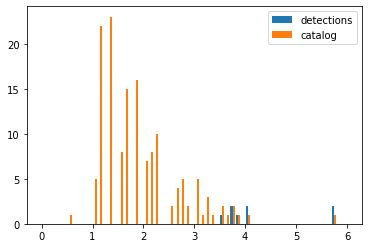

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 10 - 8

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=10, trig_off=8)
events

Event:	2019-09-26T07:32:19.349000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/25e3d4a2-4e28-4e01-adf7-52bfbad33f7a")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 46, 946692))
	          ---------
	      comments: 1 Elements
	         picks: 41 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/1e9b868b-b795-4be5-b6bc-0756b228e5fe"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 419000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/38dbe0ae-960a-468b-9bec-0c160ab54a5b"), time=UTCDateTime(2019, 9, 26, 7, 32, 24, 169000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/671109f2-cdd4-470d-9a84-76affede295d"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 109000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/d6766ecc-67c1-4718-b908-9622b03863aa"), time=UTCDateTime(2019, 9, 26, 11, 26, 45, 639000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.419000Z,
 2019-09-26T07:32:24.169000Z,
 2019-09-26T10:59:33.109000Z,
 2019-09-26T11:26:45.639000Z,
 2019-09-26T11:26:50.839000Z,
 2019-09-26T12:15:20.079000Z,
 2019-09-26T12:17:23.879000Z,
 2019-09-26T12:17:33.119000Z,
 2019-09-26T12:26:20.519000Z,
 2019-09-26T12:26:25.589000Z,
 2019-09-26T12:59:13.839000Z,
 2019-09-26T13:44:52.429000Z,
 2019-09-26T13:57:16.659000Z,
 2019-09-26T13:57:18.439000Z,
 2019-09-26T15:39:38.279000Z,
 2019-09-26T20:02:54.789000Z,
 2019-09-26T20:20:27.919000Z,
 2019-09-26T20:20:32.469000Z,
 2019-09-26T20:20:42.479000Z,
 2019-09-26T07:32:20.349000Z,
 2019-09-26T07:32:23.479000Z,
 2019-09-26T10:59:33.419000Z,
 2019-09-26T11:26:46.559000Z,
 2019-09-26T11:26:50.689000Z,
 2019-09-26T11:34:16.939000Z,
 2019-09-26T11:34:20.639000Z,
 2019-09-26T12:15:19.659000Z,
 2019-09-26T12:15:24.549000Z,
 2019-09-26T12:17:23.339000Z,
 2019-09-26T12:26:25.349000Z,
 2019-09-26T12:26:29.959000Z,
 2019-09-26T12:59:13.649000Z,
 2019-09-26T13:33:57.699000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

41

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

7

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.8999999999999999,
 5.7999999999999998,
 4.0999999999999996,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

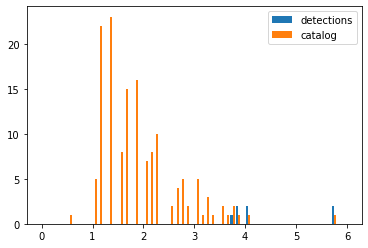

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

## Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher threshold value is changing. "thres" array consists of the threshold values, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm**

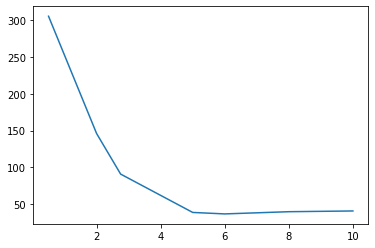

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det = np.array([305,146,91,39,37,40,41])
plt.plot(thres, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

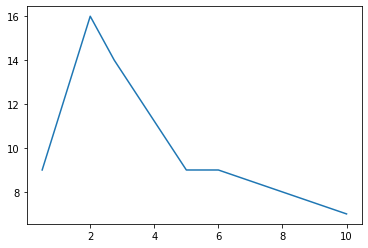

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det_cor = np.array([9,16,14,9,9,8,7])
plt.plot(thres, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# With ObsPy (Taper Applied and Mean Removed)

## Reading the data and Preprocess

In [ ]:
st= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ')

In [ ]:
st = st.copy().detrend().taper(0.05)

In [ ]:
tr1=st[0]
tr2=st[1]
tr3=st[2]

# The Effect of the Threshold

## 0.5-0.25

In [ ]:
df = tr1.stats.sampling_rate

#Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 0.5, 0.25)

In [ ]:
on_of.shape
#the first component of the matrix is the number of the detection by the algorithm

(349, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
detection_times
#the dates of the detections by the algorithm(the locations of the lines that are shown in the previous presentation)

[2019-09-26T00:00:59.998993Z,
 2019-09-26T00:20:16.438859Z,
 2019-09-26T00:22:57.618841Z,
 2019-09-26T00:23:46.868835Z,
 2019-09-26T00:24:19.678831Z,
 2019-09-26T00:27:54.078806Z,
 2019-09-26T00:29:35.788794Z,
 2019-09-26T00:33:43.578766Z,
 2019-09-26T00:36:00.668750Z,
 2019-09-26T00:36:37.328746Z,
 2019-09-26T00:37:25.948740Z,
 2019-09-26T00:38:10.158735Z,
 2019-09-26T00:38:41.858731Z,
 2019-09-26T00:39:11.188728Z,
 2019-09-26T00:40:30.048719Z,
 2019-09-26T00:41:39.368711Z,
 2019-09-26T00:43:30.418698Z,
 2019-09-26T00:44:05.118694Z,
 2019-09-26T00:44:29.528691Z,
 2019-09-26T00:44:52.868688Z,
 2019-09-26T00:44:56.068688Z,
 2019-09-26T00:45:04.638687Z,
 2019-09-26T00:45:30.138684Z,
 2019-09-26T00:45:56.498681Z,
 2019-09-26T00:46:23.478678Z,
 2019-09-26T00:47:07.708673Z,
 2019-09-26T00:47:28.018670Z,
 2019-09-26T00:49:02.198659Z,
 2019-09-26T00:49:33.638656Z,
 2019-09-26T00:49:56.568653Z,
 2019-09-26T00:51:22.188643Z,
 2019-09-26T00:51:40.668641Z,
 2019-09-26T00:53:03.968631Z,
 2019-09-2

In [ ]:
num_detect_tim=len(detection_times)
num_detect_tim
#the number of detections by the algorithm

349

In [ ]:
cat_time26=len(utc_time26)
cat_time26
#the number of the dates when the earthquake occurred in the catalog

146

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

7

In [ ]:
correct_det_times
#the dates of correct earthquakes.

[2019-09-26T11:13:31.340000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T22:04:48.076000Z,
 2019-09-26T23:15:09.266000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[2.2999999999999998,
 1.8999999999999999,
 3.2000000000000002,
 3.7000000000000002,
 2.2000000000000002,
 1.3999999999999999,
 1.2]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

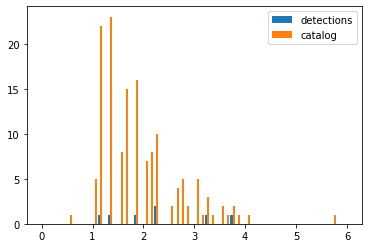

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2- 0.5

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 2, 0.5)

In [ ]:
on_of.shape
#the first component of the matrix is the number of the detectionby the algorithm

(587, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
detection_times
#the dates of the detections by the algorithm

[2019-09-26T00:00:59.998993Z,
 2019-09-26T00:12:12.458915Z,
 2019-09-26T00:12:33.798913Z,
 2019-09-26T00:13:18.768908Z,
 2019-09-26T00:13:40.408905Z,
 2019-09-26T00:14:01.818903Z,
 2019-09-26T00:14:39.908898Z,
 2019-09-26T00:15:00.028896Z,
 2019-09-26T00:15:11.328895Z,
 2019-09-26T00:15:50.688890Z,
 2019-09-26T00:16:18.378887Z,
 2019-09-26T00:16:56.148882Z,
 2019-09-26T00:17:14.278880Z,
 2019-09-26T00:18:19.208873Z,
 2019-09-26T00:18:39.968870Z,
 2019-09-26T00:19:24.358865Z,
 2019-09-26T00:19:47.738863Z,
 2019-09-26T00:20:26.208858Z,
 2019-09-26T00:20:42.948856Z,
 2019-09-26T00:21:53.448848Z,
 2019-09-26T00:22:26.948844Z,
 2019-09-26T00:23:01.268840Z,
 2019-09-26T00:23:26.058837Z,
 2019-09-26T00:23:50.968834Z,
 2019-09-26T00:24:25.958830Z,
 2019-09-26T00:25:45.378821Z,
 2019-09-26T00:26:14.448818Z,
 2019-09-26T00:26:33.268816Z,
 2019-09-26T00:27:20.518810Z,
 2019-09-26T00:27:57.508806Z,
 2019-09-26T00:28:23.068803Z,
 2019-09-26T00:29:20.538796Z,
 2019-09-26T00:30:06.248791Z,
 2019-09-2

In [ ]:
num_detect_tim=len(detection_times)
num_detect_tim
#the number of the detections by the algorithm

587

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count
#the number of the correct earthquakes which is detected by the algorithm also there is 3 seconds tolerance(by loop)

21

In [ ]:
correct_det_times
#the dates of the correct earthquakes

[2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T14:02:04.180000Z,
 2019-09-26T14:07:59.316000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T15:50:46.907000Z,
 2019-09-26T15:52:27.570000Z,
 2019-09-26T18:06:30.840000Z,
 2019-09-26T18:40:02.146000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T19:56:13.577000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:36:29.982000Z,
 2019-09-26T21:01:03.886000Z,
 2019-09-26T21:01:03.886000Z,
 2019-09-26T21:23:53.417000Z,
 2019-09-26T21:42:25.860000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[2.8999999999999999,
 5.7999999999999998,
 3.3999999999999999,
 3.7000000000000002,
 3.0,
 2.7000000000000002,
 2.6000000000000001,
 3.0,
 1.8,
 1.8,
 1.2,
 1.2,
 2.2000000000000002,
 1.5,
 3.5,
 1.3,
 1.1000000000000001,
 1.8,
 1.1000000000000001,
 1.8,
 1.7,
 1.7,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

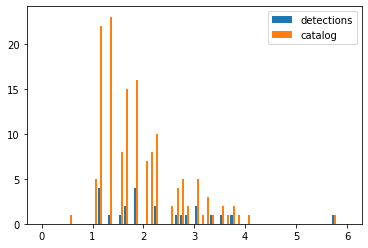

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2.75 - 1.75

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(249, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

18

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T14:07:59.316000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T21:23:53.417000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

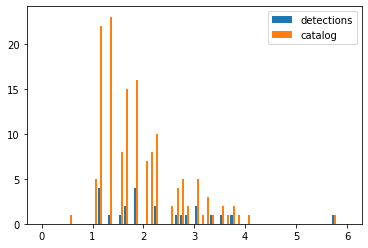

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 5-2

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 5, 2)

In [ ]:
on_of.shape

(40, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

12

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

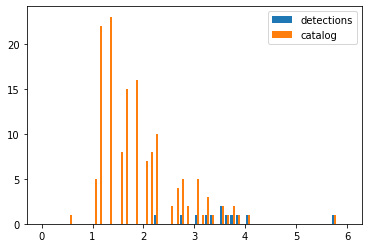

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 6-4

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 6, 4)

In [ ]:
on_of.shape

(38, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

11

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.2000000000000002,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

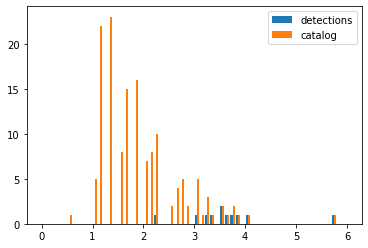

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 8-6

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 8, 6)

In [ ]:
on_of.shape

(30, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

10

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

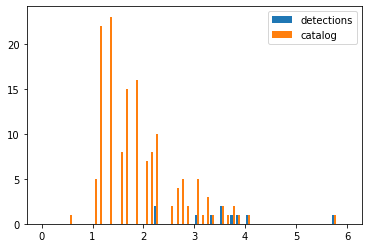

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 10 - 8

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
on_of = trigger_onset(cft, 10, 8)

In [ ]:
on_of.shape

(32, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

9

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

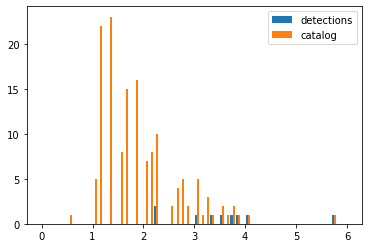

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

## Overall Graphs

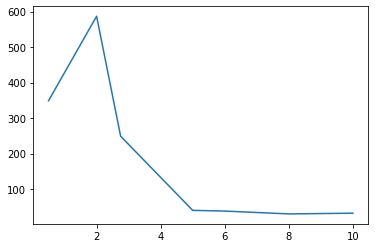

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det = np.array([349,587,249,40,38,30,32])
plt.plot(thres, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

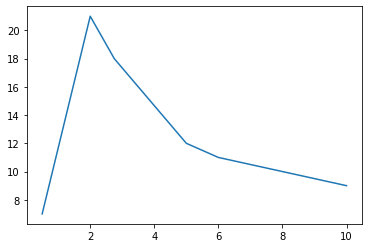

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det_cor = np.array([7,21,18,12,11,10,9])
plt.plot(thres, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# APPENDIX 2 : With EqCorrscan ( Taper Applied and Mean Removed)

## Reading the Data

In [ ]:
st=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE', format="SAC")
st+=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ', format="SAC")
st+=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN',format="SAC")

In [ ]:
st.merge(method=0,fill_value='interpolate', interpolation_samples=1)

3 Trace(s) in Stream:
KO.SLVT..HHE | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples
KO.SLVT..HHN | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples
KO.SLVT..HHZ | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples

In [ ]:
st = st.copy().detrend().taper(0.05)

In [ ]:
tr1=st[0]
tr2=st[1]#obtaining traces
tr3=st[2]

# The Effect of the Threshold

## 0.5-0.25

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=0.5, trig_off=0.25)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/4756d454-d2b7-442f-b16f-9d432b8f5f88")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 2, 57, 119969))
	          ---------
	      comments: 1 Elements
	         picks: 9899 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/2b843e3e-7622-457b-9cbb-bc83365dfedd"), time=UTCDateTime(2019, 9, 26, 0, 0, 59, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/f5006b84-9ec3-4cad-a92c-f1fea11ff1e4"), time=UTCDateTime(2019, 9, 26, 0, 1, 57, 879000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/6a2d49c3-4218-420b-a648-4619ba9ffd34"), time=UTCDateTime(2019, 9, 26, 0, 3, 47, 929000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/ba60ffb8-907e-4ce2-b0a6-d40af94fa980"), time=UTCDateTime(2019, 9, 26, 0, 5, 41, 139000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:00:59.989000Z,
 2019-09-26T00:01:57.879000Z,
 2019-09-26T00:03:47.929000Z,
 2019-09-26T00:05:41.139000Z,
 2019-09-26T00:06:08.849000Z,
 2019-09-26T00:06:28.269000Z,
 2019-09-26T00:06:36.239000Z,
 2019-09-26T00:07:00.009000Z,
 2019-09-26T00:07:13.039000Z,
 2019-09-26T00:08:06.719000Z,
 2019-09-26T00:08:21.149000Z,
 2019-09-26T00:08:47.129000Z,
 2019-09-26T00:08:54.799000Z,
 2019-09-26T00:09:02.429000Z,
 2019-09-26T00:09:06.459000Z,
 2019-09-26T00:09:38.579000Z,
 2019-09-26T00:10:45.439000Z,
 2019-09-26T00:11:15.339000Z,
 2019-09-26T00:11:28.339000Z,
 2019-09-26T00:11:42.989000Z,
 2019-09-26T00:11:53.399000Z,
 2019-09-26T00:12:03.619000Z,
 2019-09-26T00:12:06.499000Z,
 2019-09-26T00:12:11.319000Z,
 2019-09-26T00:12:24.359000Z,
 2019-09-26T00:12:29.639000Z,
 2019-09-26T00:12:59.019000Z,
 2019-09-26T00:13:05.959000Z,
 2019-09-26T00:13:10.929000Z,
 2019-09-26T00:13:15.159000Z,
 2019-09-26T00:13:25.689000Z,
 2019-09-26T00:13:38.039000Z,
 2019-09-26T00:13:49.139000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

9899

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

83

In [ ]:
correct_det_times

[2019-09-26T04:05:48.160000Z,
 2019-09-26T11:09:07.488000Z,
 2019-09-26T11:11:42.408000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:17:02.968000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:21:24.720000Z,
 2019-09-26T11:31:59.370000Z,
 2019-09-26T11:38:24.648000Z,
 2019-09-26T11:43:02.870000Z,
 2019-09-26T11:43:04.108000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T13:48:45.316000Z,
 2019-09-26T17:26:39.017000Z,
 2019-09-26T17:31:39.576000Z,
 2019-09-26T17:36:28.836000Z,
 2019-09-26T17:59:29.346000Z,
 2019-09-26T18:22:23.357000Z,
 2019-09-26T18:40:02.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:06:29.346000Z,
 2019-09-26T20:30:32.017000Z,
 2019-09-26T21:29:31.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T22:04:48.076000Z,
 2019-09-26T23:15:09.266000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T23:49:43.017000Z,
 2019-09-26T04:05:48.160000Z,
 2019-09-26T08:27:16.187000Z,
 2019-09-26T11:11:42.408000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[2.1000000000000001,
 3.1000000000000001,
 3.2999999999999998,
 2.2999999999999998,
 2.6000000000000001,
 1.8999999999999999,
 2.1000000000000001,
 3.0,
 1.3999999999999999,
 2.6000000000000001,
 2.6000000000000001,
 3.7000000000000002,
 1.1000000000000001,
 1.1000000000000001,
 1.2,
 1.3,
 1.6000000000000001,
 1.3999999999999999,
 1.2,
 3.5,
 1.8,
 1.5,
 1.0,
 2.2000000000000002,
 1.3999999999999999,
 1.2,
 2.2000000000000002,
 1.5,
 2.1000000000000001,
 2.2999999999999998,
 3.2999999999999998,
 2.2999999999999998,
 2.8999999999999999,
 2.1000000000000001,
 2.1000000000000001,
 2.0,
 2.2000000000000002,
 2.7999999999999998,
 1.3999999999999999,
 2.0,
 2.0,
 2.0,
 2.7000000000000002,
 3.7000000000000002,
 3.7000000000000002,
 3.7000000000000002,
 1.6000000000000001,
 2.7999999999999998,
 1.1000000000000001,
 3.2000000000000002,
 2.6000000000000001,
 1.3,
 1.3999999999999999,
 1.3,
 1.5,
 1.3,
 3.0,
 1.2,
 1.8,
 1.1000000000000001,
 1.3,
 1.1000000000000001,
 1.1000000000000001,
 1.6000

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

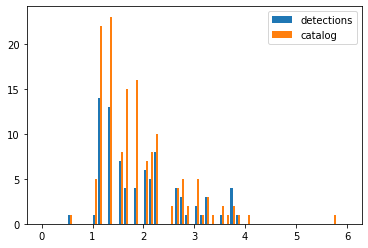

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 2- 0.5

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=2, trig_off=0.5)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/063e8dc4-d5a4-42f4-8187-e696c7961bba")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 5, 34, 597621))
	          ---------
	      comments: 1 Elements
	         picks: 5875 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/fb4c9dd0-ad3a-49bf-be8f-230dc865fb9e"), time=UTCDateTime(2019, 9, 26, 0, 0, 59, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/9ab323f1-8694-4eaf-b50a-e7b58f29d6e8"), time=UTCDateTime(2019, 9, 26, 0, 1, 36, 219000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/50854f77-1f3a-4602-be17-25f12dbbd6d7"), time=UTCDateTime(2019, 9, 26, 0, 1, 58, 389000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4f11d479-bbb2-4378-b88a-d6e628d703c8"), time=UTCDateTime(2019, 9, 26, 0, 2, 30, 619000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:00:59.989000Z,
 2019-09-26T00:01:36.219000Z,
 2019-09-26T00:01:58.389000Z,
 2019-09-26T00:02:30.619000Z,
 2019-09-26T00:02:34.659000Z,
 2019-09-26T00:02:38.169000Z,
 2019-09-26T00:03:09.699000Z,
 2019-09-26T00:03:17.499000Z,
 2019-09-26T00:03:30.189000Z,
 2019-09-26T00:03:33.759000Z,
 2019-09-26T00:03:37.599000Z,
 2019-09-26T00:03:48.659000Z,
 2019-09-26T00:03:53.059000Z,
 2019-09-26T00:03:59.629000Z,
 2019-09-26T00:04:03.839000Z,
 2019-09-26T00:04:14.739000Z,
 2019-09-26T00:04:21.679000Z,
 2019-09-26T00:04:25.749000Z,
 2019-09-26T00:04:29.869000Z,
 2019-09-26T00:04:33.219000Z,
 2019-09-26T00:04:46.519000Z,
 2019-09-26T00:04:57.709000Z,
 2019-09-26T00:05:01.139000Z,
 2019-09-26T00:05:04.889000Z,
 2019-09-26T00:05:07.839000Z,
 2019-09-26T00:05:11.099000Z,
 2019-09-26T00:05:15.119000Z,
 2019-09-26T00:05:18.829000Z,
 2019-09-26T00:05:22.669000Z,
 2019-09-26T00:05:30.609000Z,
 2019-09-26T00:05:34.319000Z,
 2019-09-26T00:05:37.689000Z,
 2019-09-26T00:05:42.229000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

5875

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

102

In [ ]:
correct_det_times

[2019-09-26T04:05:48.160000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T08:27:16.187000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:31:59.370000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:17:53.586000Z,
 2019-09-26T13:25:52.317000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T14:02:04.180000Z,
 2019-09-26T14:10:45.410000Z,
 2019-09-26T15:50:46.907000Z,
 2019-09-26T15:52:27.570000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:45:21.077000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T17:03:39.480000Z,
 2019-09-26T18:02:59.767000Z,
 2019-09-26T18:06:30.840000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-26T18:26:51.836000Z,
 2019-09-26T18:40:02.146000Z,
 2019-09-26T18:40:02.146000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[2.1000000000000001,
 3.6000000000000001,
 2.2999999999999998,
 2.8999999999999999,
 2.8999999999999999,
 5.7999999999999998,
 2.2999999999999998,
 1.8999999999999999,
 3.0,
 3.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 1.3999999999999999,
 2.1000000000000001,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 2.7000000000000002,
 2.1000000000000001,
 1.8,
 1.8,
 2.2999999999999998,
 1.3,
 1.8999999999999999,
 1.8,
 1.8999999999999999,
 1.2,
 2.0,
 1.8,
 1.2,
 1.2,
 2.2000000000000002,
 2.0,
 1.5,
 3.5,
 1.2,
 1.3,
 1.5,
 1.2,
 1.3999999999999999,
 1.1000000000000001,
 1.8,
 1.1000000000000001,
 1.8,
 1.7,
 2.1000000000000001,
 2.2000000000000002,
 1.3999999999999999,
 1.2,
 2.2000000000000002,
 3.6000000000000001,
 2.8999999999999999,
 5.7999999999999998,
 2.8999999999999999,
 4.0999999999999996,
 3.0,
 3.2000000000000002,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 2.2000

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

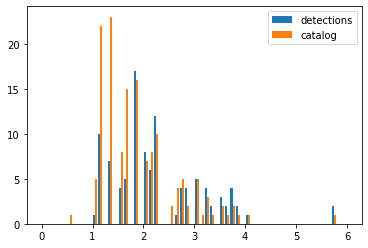

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 2.75 - 1.75

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/e034875f-4285-499d-ba27-4a834f025001")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 6, 38, 996479))
	          ---------
	      comments: 1 Elements
	         picks: 2318 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/2aa0d4b6-a5b7-4863-a0c9-c2bb5832ca5e"), time=UTCDateTime(2019, 9, 26, 0, 0, 59, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/ad462504-aca5-46a1-adc4-14721d4b4313"), time=UTCDateTime(2019, 9, 26, 0, 1, 2, 129000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/51380709-ca06-4e12-9b04-2c38c129fe53"), time=UTCDateTime(2019, 9, 26, 0, 1, 6, 259000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/27b2983f-4657-4b8b-996b-2f4328213cc5"), time=UTCDateTime(2019, 9, 26, 0, 1, 10, 609000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(r

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:00:59.989000Z,
 2019-09-26T00:01:02.129000Z,
 2019-09-26T00:01:06.259000Z,
 2019-09-26T00:01:10.609000Z,
 2019-09-26T00:01:14.289000Z,
 2019-09-26T00:01:18.139000Z,
 2019-09-26T00:01:21.909000Z,
 2019-09-26T00:01:29.229000Z,
 2019-09-26T00:01:32.699000Z,
 2019-09-26T00:01:36.379000Z,
 2019-09-26T00:01:40.219000Z,
 2019-09-26T00:01:46.679000Z,
 2019-09-26T00:01:50.429000Z,
 2019-09-26T00:01:54.389000Z,
 2019-09-26T00:01:58.619000Z,
 2019-09-26T00:02:08.099000Z,
 2019-09-26T00:02:12.489000Z,
 2019-09-26T00:02:15.739000Z,
 2019-09-26T00:02:20.159000Z,
 2019-09-26T00:02:23.569000Z,
 2019-09-26T00:02:27.299000Z,
 2019-09-26T00:02:30.859000Z,
 2019-09-26T00:02:34.839000Z,
 2019-09-26T00:02:38.359000Z,
 2019-09-26T00:02:42.259000Z,
 2019-09-26T00:02:48.179000Z,
 2019-09-26T00:02:51.079000Z,
 2019-09-26T00:03:06.579000Z,
 2019-09-26T00:03:09.919000Z,
 2019-09-26T00:03:13.559000Z,
 2019-09-26T00:03:30.379000Z,
 2019-09-26T00:03:34.039000Z,
 2019-09-26T00:03:45.219000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

2318

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

76

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T14:02:04.180000Z,
 2019-09-26T14:07:59.316000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T15:52:27.570000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T17:03:39.480000Z,
 2019-09-26T18:06:30.840000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-26T18:26:51.836000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:15:29.406000Z,
 2019-09-26T20:15:29.406000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T20:26:29.946000Z,
 2019-09-26T20:36:29.982000Z,
 2019-09-26T21:01:03.886000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 2.8999999999999999,
 5.7999999999999998,
 2.2999999999999998,
 1.8999999999999999,
 2.8999999999999999,
 4.0999999999999996,
 3.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 2.7000000000000002,
 2.6000000000000001,
 3.0,
 1.8,
 2.2999999999999998,
 1.8999999999999999,
 1.8,
 1.2,
 2.0,
 1.8,
 2.2000000000000002,
 3.5,
 2.0,
 2.0,
 3.8999999999999999,
 1.2,
 1.3,
 1.1000000000000001,
 1.8,
 1.1000000000000001,
 1.8,
 1.7,
 1.7,
 2.1000000000000001,
 1.3999999999999999,
 2.2000000000000002,
 1.3999999999999999,
 2.2000000000000002,
 3.6000000000000001,
 2.8999999999999999,
 5.7999999999999998,
 2.8999999999999999,
 4.0999999999999996,
 3.2000000000000002,
 2.0,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 2.7000000000000002,
 2.6000000000000001,
 1.7,
 1.5,
 3.0,
 1.8,
 1.8,
 1.8,
 1.3999999999999999,
 1.3999999

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

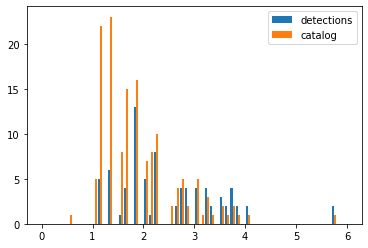

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 5-2

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=5, trig_off=2)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/a6f18d6e-dc96-43c2-8ee6-e2fa5d5515ac")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 6, 54, 652427))
	          ---------
	      comments: 1 Elements
	         picks: 231 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/85f1307a-da4c-40ac-8f52-c6b2821a7214"), time=UTCDateTime(2019, 9, 26, 0, 0, 59, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a81e1baa-af98-4c9f-99ec-9191b215fcf0"), time=UTCDateTime(2019, 9, 26, 0, 1, 2, 819000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4e1a1af3-651a-4f0c-bf96-c98dfd830059"), time=UTCDateTime(2019, 9, 26, 0, 1, 7, 329000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/e4994f72-249e-4dbe-a3b8-5119e102e17f"), time=UTCDateTime(2019, 9, 26, 0, 1, 11, 109000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(r

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:00:59.989000Z,
 2019-09-26T00:01:02.819000Z,
 2019-09-26T00:01:07.329000Z,
 2019-09-26T00:01:11.109000Z,
 2019-09-26T00:01:14.679000Z,
 2019-09-26T00:01:18.549000Z,
 2019-09-26T00:01:29.979000Z,
 2019-09-26T00:01:33.079000Z,
 2019-09-26T00:01:37.109000Z,
 2019-09-26T00:01:54.819000Z,
 2019-09-26T00:41:47.579000Z,
 2019-09-26T00:44:09.559000Z,
 2019-09-26T07:32:15.399000Z,
 2019-09-26T09:00:30.319000Z,
 2019-09-26T10:59:32.979000Z,
 2019-09-26T11:20:08.599000Z,
 2019-09-26T11:26:44.909000Z,
 2019-09-26T11:32:05.309000Z,
 2019-09-26T11:34:13.019000Z,
 2019-09-26T11:43:11.829000Z,
 2019-09-26T11:51:41.039000Z,
 2019-09-26T12:00:41.139000Z,
 2019-09-26T12:04:04.369000Z,
 2019-09-26T12:04:34.079000Z,
 2019-09-26T12:15:14.039000Z,
 2019-09-26T12:17:18.509000Z,
 2019-09-26T12:26:19.539000Z,
 2019-09-26T12:34:32.729000Z,
 2019-09-26T12:59:08.809000Z,
 2019-09-26T13:33:53.829000Z,
 2019-09-26T13:44:46.589000Z,
 2019-09-26T13:57:09.899000Z,
 2019-09-26T14:02:09.409000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim
#the number of the detections by the algorithm

231

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

37

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T14:07:59.316000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T15:50:46.907000Z,
 2019-09-26T15:52:27.570000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 2.2000000000000002,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 2.6000000000000001,
 3.0,
 1.8,
 1.8,
 2.2999999999999998,
 1.8999999999999999,
 2.0,
 1.8,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

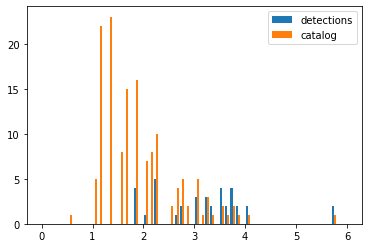

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 6-4

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=6, trig_off=4)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/b8078d5a-e9ef-4eb9-9772-51537079e0b6")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 6, 56, 78231))
	          ---------
	      comments: 1 Elements
	         picks: 158 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/6cc2d294-afef-476f-8960-567d7ccbdd2f"), time=UTCDateTime(2019, 9, 26, 0, 1, 3, 389000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/48c99ac8-af37-416f-8996-25dfc64e4678"), time=UTCDateTime(2019, 9, 26, 0, 1, 11, 379000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a91ec542-6938-494a-ab3f-2386a3cbd395"), time=UTCDateTime(2019, 9, 26, 0, 1, 14, 879000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4ad441f9-d0e7-4d0b-a129-8fb7139ba972"), time=UTCDateTime(2019, 9, 26, 0, 1, 33, 299000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:01:03.389000Z,
 2019-09-26T00:01:11.379000Z,
 2019-09-26T00:01:14.879000Z,
 2019-09-26T00:01:33.299000Z,
 2019-09-26T00:01:37.649000Z,
 2019-09-26T00:01:55.109000Z,
 2019-09-26T00:44:10.019000Z,
 2019-09-26T07:32:15.519000Z,
 2019-09-26T09:00:30.399000Z,
 2019-09-26T10:59:32.989000Z,
 2019-09-26T11:20:08.649000Z,
 2019-09-26T11:20:15.719000Z,
 2019-09-26T11:26:44.939000Z,
 2019-09-26T11:32:05.529000Z,
 2019-09-26T11:34:16.729000Z,
 2019-09-26T11:43:12.569000Z,
 2019-09-26T11:51:41.489000Z,
 2019-09-26T12:04:35.629000Z,
 2019-09-26T12:15:14.199000Z,
 2019-09-26T12:17:18.629000Z,
 2019-09-26T12:26:19.549000Z,
 2019-09-26T12:34:32.849000Z,
 2019-09-26T12:59:08.969000Z,
 2019-09-26T13:33:57.309000Z,
 2019-09-26T13:44:46.939000Z,
 2019-09-26T13:57:10.629000Z,
 2019-09-26T14:02:09.719000Z,
 2019-09-26T14:08:05.209000Z,
 2019-09-26T14:10:53.559000Z,
 2019-09-26T15:39:30.459000Z,
 2019-09-26T16:35:39.279000Z,
 2019-09-26T17:03:47.099000Z,
 2019-09-26T18:03:06.689000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim
#number of detection by the algorithm

158

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

35

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T15:52:27.570000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-26T18:26:51.836000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 2.2000000000000002,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 1.8,
 2.2999999999999998,
 1.8999999999999999,
 2.0,
 1.8,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

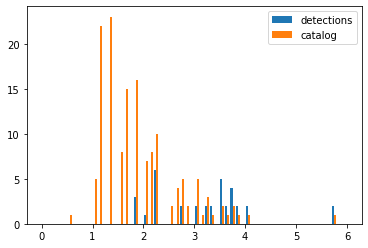

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=8, trig_off=6)
events

Event:	2019-09-26T00:01:10.149000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/e5005bae-dc03-4bd5-ac22-14833222f26e")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 6, 57, 276677))
	          ---------
	      comments: 1 Elements
	         picks: 158 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/b2ac5863-1141-42a6-8eaa-7cb801fa184a"), time=UTCDateTime(2019, 9, 26, 7, 32, 15, 859000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/f5c20fe9-15da-4d3b-ac56-6de5c98c1cdd"), time=UTCDateTime(2019, 9, 26, 9, 0, 30, 459000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/6314d883-ec92-46f7-9847-4ca7dfc9f747"), time=UTCDateTime(2019, 9, 26, 10, 59, 32, 999000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/b097c49b-a54b-49d3-aadf-166483f56df1"), time=UTCDateTime(2019, 9, 26, 11, 20, 8, 939000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 



In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:15.859000Z,
 2019-09-26T09:00:30.459000Z,
 2019-09-26T10:59:32.999000Z,
 2019-09-26T11:20:08.939000Z,
 2019-09-26T11:26:44.979000Z,
 2019-09-26T11:32:05.619000Z,
 2019-09-26T11:34:16.749000Z,
 2019-09-26T11:43:13.539000Z,
 2019-09-26T11:51:42.619000Z,
 2019-09-26T12:15:14.379000Z,
 2019-09-26T12:17:19.019000Z,
 2019-09-26T12:17:32.409000Z,
 2019-09-26T12:26:19.569000Z,
 2019-09-26T12:26:25.359000Z,
 2019-09-26T12:34:33.549000Z,
 2019-09-26T12:59:09.749000Z,
 2019-09-26T12:59:13.459000Z,
 2019-09-26T13:33:57.489000Z,
 2019-09-26T13:44:48.039000Z,
 2019-09-26T13:57:10.999000Z,
 2019-09-26T13:57:14.699000Z,
 2019-09-26T14:02:09.749000Z,
 2019-09-26T14:02:16.309000Z,
 2019-09-26T14:08:05.269000Z,
 2019-09-26T15:39:30.529000Z,
 2019-09-26T16:35:39.339000Z,
 2019-09-26T18:21:06.099000Z,
 2019-09-26T19:10:13.219000Z,
 2019-09-26T19:20:10.709000Z,
 2019-09-26T19:44:04.289000Z,
 2019-09-26T20:02:48.829000Z,
 2019-09-26T20:06:36.929000Z,
 2019-09-26T20:20:26.929000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim
#number of detection by the algorithm

158

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

56

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 1.8999999999999999,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 2.2999999999999998,
 1.8999999999999999,
 1.8,
 1.8999999999999999,
 1.2,
 2.0,
 1.8,
 1.2,
 2.2000000000000002,
 2.0,
 3.5,
 3.8999999999999999,
 1.7,
 2.1000000000000001,
 2.2000000000000002,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

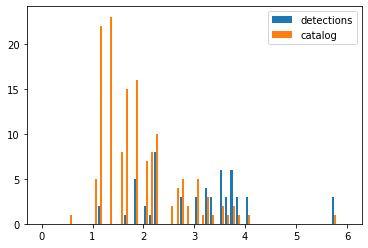

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 10 - 8

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=10, trig_off=8)
events

Event:	2019-09-26T02:00:06.619000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/876a61b0-7886-4b9f-86b9-c5456a71f307")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 6, 58, 398023))
	          ---------
	      comments: 1 Elements
	         picks: 146 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/77e566a7-c010-4bc2-a640-a8a1fab4217e"), time=UTCDateTime(2019, 9, 26, 7, 32, 16, 549000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/bd94363d-f675-4d16-a758-8c53aa21274d"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 209000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/91ce9caf-07e0-4497-84ed-2160dcb023ae"), time=UTCDateTime(2019, 9, 26, 7, 32, 26, 979000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4d19ea20-3a58-47c5-996f-358a15814fc4"), time=UTCDateTime(2019, 9, 26, 9, 0, 30, 679000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

P

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:16.549000Z,
 2019-09-26T07:32:20.209000Z,
 2019-09-26T07:32:26.979000Z,
 2019-09-26T09:00:30.679000Z,
 2019-09-26T09:00:33.809000Z,
 2019-09-26T10:59:33.019000Z,
 2019-09-26T11:20:09.279000Z,
 2019-09-26T11:20:11.889000Z,
 2019-09-26T11:26:45.169000Z,
 2019-09-26T11:26:50.739000Z,
 2019-09-26T11:32:06.129000Z,
 2019-09-26T11:32:09.069000Z,
 2019-09-26T11:34:16.769000Z,
 2019-09-26T12:15:14.429000Z,
 2019-09-26T12:15:19.379000Z,
 2019-09-26T12:17:19.289000Z,
 2019-09-26T12:17:23.509000Z,
 2019-09-26T12:17:33.059000Z,
 2019-09-26T12:26:19.579000Z,
 2019-09-26T12:26:25.389000Z,
 2019-09-26T12:59:09.999000Z,
 2019-09-26T12:59:13.499000Z,
 2019-09-26T13:33:57.499000Z,
 2019-09-26T13:44:51.449000Z,
 2019-09-26T13:57:12.749000Z,
 2019-09-26T13:57:14.739000Z,
 2019-09-26T14:02:09.819000Z,
 2019-09-26T14:08:05.739000Z,
 2019-09-26T15:39:30.749000Z,
 2019-09-26T15:39:35.169000Z,
 2019-09-26T16:35:39.359000Z,
 2019-09-26T18:21:06.239000Z,
 2019-09-26T19:10:13.269000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

146

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

43

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 2.2999999999999998,
 1.8999999999999999,
 1.2,
 2.0,
 1.8,
 2.2000000000000002,
 3.5,
 3.8999999999999999,
 1.7,
 2.1000000000000001,
 2.2000000000000002,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

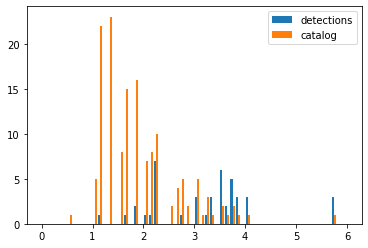

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

## Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher threshold value is changing. "thres" array consists of the threshold values, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm**

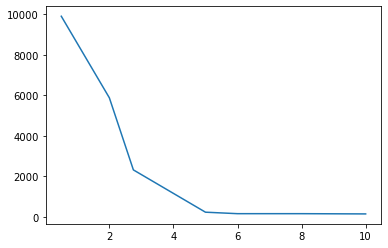

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det = np.array([9899,5875,2318,231,158,158,146])
plt.plot(thres, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

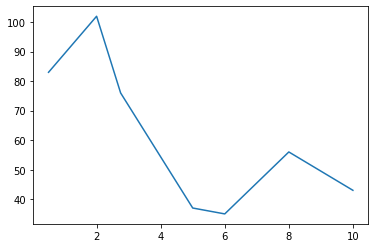

In [ ]:
thres = np.array([0.5,2,2.75,5,6,8,10])
num_det_cor = np.array([83,102,76,37,35,56,43])
plt.plot(thres, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# Part 2 : Comparison with Window-size

# With ObsPy (Nothing Applied)

## Reading the data

In [ ]:
st= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ')

In [ ]:
tr1=st[0]
tr2=st[1]#obtaining traces
tr3=st[2]

# The Effect of the Window-Size

## 2-60

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape
#the first component of the matrix is the number of the detection by the algorithm

(24, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
detection_times
#the dates of the detections by the algorithm (the locations of the lines that are shown in the previous presentation)

[2019-09-26T07:32:20.295859Z,
 2019-09-26T09:00:31.315246Z,
 2019-09-26T10:59:33.024420Z,
 2019-09-26T11:20:08.884277Z,
 2019-09-26T11:26:45.214231Z,
 2019-09-26T11:27:15.554227Z,
 2019-09-26T11:34:17.254179Z,
 2019-09-26T12:15:15.333894Z,
 2019-09-26T12:17:23.563879Z,
 2019-09-26T12:17:51.223876Z,
 2019-09-26T12:26:19.663817Z,
 2019-09-26T12:59:13.633589Z,
 2019-09-26T13:33:57.653347Z,
 2019-09-26T13:44:51.503272Z,
 2019-09-26T13:57:14.993186Z,
 2019-09-26T14:02:10.233152Z,
 2019-09-26T14:08:06.063110Z,
 2019-09-26T15:39:35.572475Z,
 2019-09-26T16:35:40.222086Z,
 2019-09-26T20:02:49.490647Z,
 2019-09-26T20:20:27.310525Z,
 2019-09-26T21:49:20.319907Z,
 2019-09-26T23:04:09.109388Z,
 2019-09-26T23:48:23.789081Z]

In [ ]:
num_detect_tim=len(detection_times)
num_detect_tim
#the number of detections by the algorithm

24

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

6

In [ ]:
correct_det_times
#the dates of correct earthquakes.

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

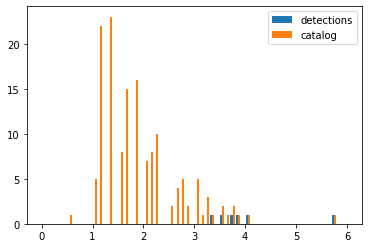

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 10-80

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(10*df),int(df*80))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(13, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

3

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 4.0999999999999996, 3.7000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

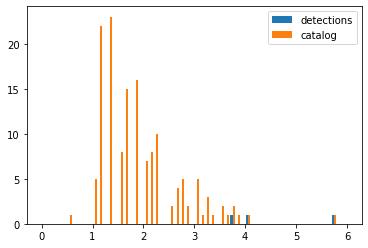

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 20-100

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(20*df),int(df*100))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(11, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

1

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

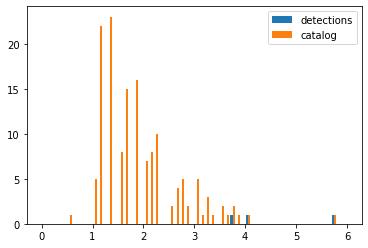

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 20-500

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(20*df),int(df*500))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(12, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

1

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

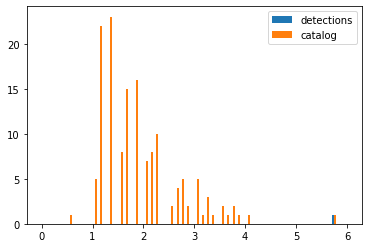

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 30-1000

In [ ]:
df = tr1.stats.sampling_rate

cft = recursive_sta_lta(tr1.data, int(30*df),int(df*1000))
on_of = trigger_onset(cft, 2.75,1.75)

In [ ]:
on_of.shape

(7, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

1

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

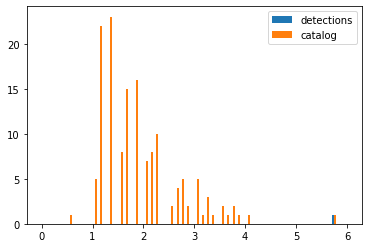

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 40-2000

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(40*df),int(df*2000))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(4, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

1

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

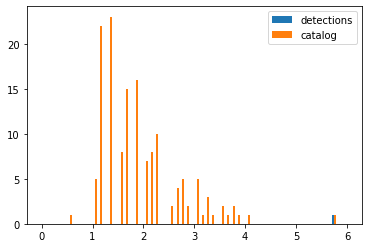

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 50-5000

In [ ]:
df = tr1.stats.sampling_rate

cft = recursive_sta_lta(tr1.data, int(50*df),int(df*5000))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(4, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

1

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

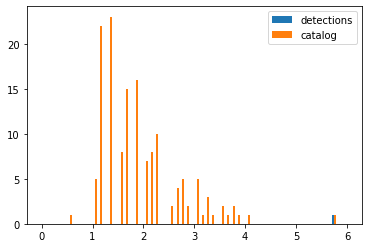

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

## Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher window-size value is changing. "window" array consists of the higher window-size values, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm and compared with the catalog, do not forget, there is three seconds tolerance.**

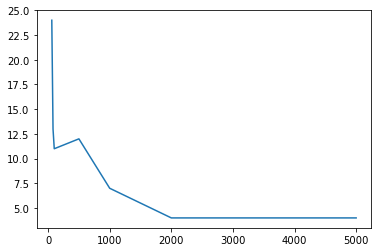

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det = np.array([24,13,11,12,7,4,4])
plt.plot(window, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

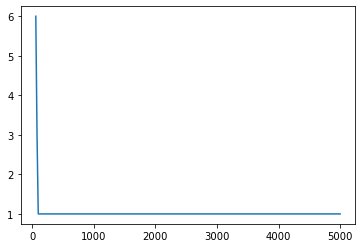

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det_cor = np.array([6,3,1,1,1,1,1])
plt.plot(window, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# APPENDIX 3 : With EqCorrscan (Nothing Applied)

## Reading the data

In [ ]:
st=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE', format="SAC")
st+=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ', format="SAC")
st+=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN',format="SAC")

In [ ]:
st.merge(method=0,fill_value='interpolate', interpolation_samples=1)

3 Trace(s) in Stream:
KO.SLVT..HHE | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples
KO.SLVT..HHN | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples
KO.SLVT..HHZ | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples

In [ ]:
tr1=st[0]
tr2=st[1]#obtaining traces
tr3=st[2]

# The Effect of the Window-size

## 2-60

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:44:08.709000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/c42ceb6f-2859-4eb0-a119-d57631571074")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 5, 467760))
	          ---------
	      comments: 1 Elements
	         picks: 91 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/d53cac3a-095b-4615-9d5c-85fcc3737f87"), time=UTCDateTime(2019, 9, 26, 0, 44, 9, 709000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4ea1c840-4b6f-44a5-8305-63c3bdd7d334"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 279000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/17b9c6cd-c0ec-4cd9-bcc0-248eb70b77b9"), time=UTCDateTime(2019, 9, 26, 7, 32, 38, 819000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/ed2bb389-dc35-4fbe-b08a-914f6a3e55b1"), time=UTCDateTime(2019, 9, 26, 7, 32, 42, 719000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

P

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:44:09.709000Z,
 2019-09-26T07:32:20.279000Z,
 2019-09-26T07:32:38.819000Z,
 2019-09-26T07:32:42.719000Z,
 2019-09-26T09:00:31.229000Z,
 2019-09-26T10:59:33.029000Z,
 2019-09-26T11:00:01.339000Z,
 2019-09-26T11:03:58.139000Z,
 2019-09-26T11:06:54.659000Z,
 2019-09-26T11:07:20.039000Z,
 2019-09-26T11:09:37.679000Z,
 2019-09-26T11:10:42.839000Z,
 2019-09-26T11:11:51.129000Z,
 2019-09-26T11:12:27.599000Z,
 2019-09-26T11:13:34.799000Z,
 2019-09-26T11:14:58.789000Z,
 2019-09-26T11:15:18.649000Z,
 2019-09-26T11:15:29.469000Z,
 2019-09-26T11:15:43.329000Z,
 2019-09-26T11:15:53.869000Z,
 2019-09-26T11:16:03.339000Z,
 2019-09-26T11:16:24.309000Z,
 2019-09-26T11:16:36.049000Z,
 2019-09-26T11:20:08.869000Z,
 2019-09-26T11:26:45.199000Z,
 2019-09-26T11:29:33.389000Z,
 2019-09-26T11:32:06.299000Z,
 2019-09-26T11:34:16.949000Z,
 2019-09-26T12:15:14.699000Z,
 2019-09-26T12:17:18.689000Z,
 2019-09-26T12:17:51.539000Z,
 2019-09-26T12:26:19.669000Z,
 2019-09-26T12:59:13.639000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

91

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

14

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 1.8999999999999999,
 4.0999999999999996,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

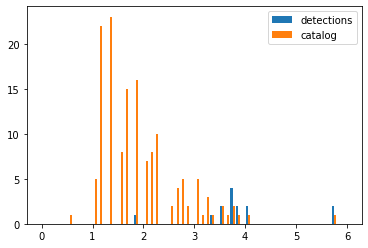

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 10-80

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=10, ltalen=80, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T07:32:19.349000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/f3bc6a74-5742-48f1-a40b-da9e5fb655bc")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 6, 706217))
	          ---------
	      comments: 1 Elements
	         picks: 37 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/8014c3a1-2724-4166-b60c-64dccd0e2f2e"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 379000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/641b46ed-6a70-4afd-b60f-aa126b1a5726"), time=UTCDateTime(2019, 9, 26, 9, 0, 37, 589000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/46be52cf-cce1-4aac-a679-ac768df7e89b"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 109000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a33ba989-9c56-4056-abad-acb409fc3ebc"), time=UTCDateTime(2019, 9, 26, 11, 20, 12, 939000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 


In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.379000Z,
 2019-09-26T09:00:37.589000Z,
 2019-09-26T10:59:33.109000Z,
 2019-09-26T11:20:12.939000Z,
 2019-09-26T11:26:45.639000Z,
 2019-09-26T11:34:19.439000Z,
 2019-09-26T12:15:19.659000Z,
 2019-09-26T12:17:23.589000Z,
 2019-09-26T12:26:20.459000Z,
 2019-09-26T12:59:13.779000Z,
 2019-09-26T13:34:00.539000Z,
 2019-09-26T13:44:52.219000Z,
 2019-09-26T13:57:16.089000Z,
 2019-09-26T14:02:15.019000Z,
 2019-09-26T15:39:36.999000Z,
 2019-09-26T16:35:47.679000Z,
 2019-09-26T20:02:51.459000Z,
 2019-09-26T20:20:27.889000Z,
 2019-09-26T07:32:20.349000Z,
 2019-09-26T09:00:34.539000Z,
 2019-09-26T10:59:33.429000Z,
 2019-09-26T11:20:12.689000Z,
 2019-09-26T11:26:46.549000Z,
 2019-09-26T11:32:09.189000Z,
 2019-09-26T11:34:16.929000Z,
 2019-09-26T12:15:19.549000Z,
 2019-09-26T12:17:23.329000Z,
 2019-09-26T12:26:22.239000Z,
 2019-09-26T12:59:13.639000Z,
 2019-09-26T13:33:57.709000Z,
 2019-09-26T13:44:51.729000Z,
 2019-09-26T13:57:14.899000Z,
 2019-09-26T14:02:11.929000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

37

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.7000000000000002,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 4.0999999999999996]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

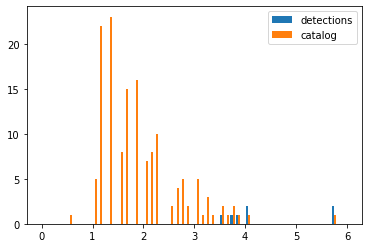

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 20-100

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=20, ltalen=100, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T07:32:19.389000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/66fab0be-02cc-46c7-9b72-9f2c131d0b77")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 8, 36337))
	          ---------
	      comments: 1 Elements
	         picks: 29 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/adf91cef-e118-479d-a014-8f02af2fa495"), time=UTCDateTime(2019, 9, 26, 7, 32, 21, 149000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/0bcba267-f782-41cc-a780-31a30253b37b"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 179000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/c93b94b1-9c98-4148-a372-96e977105bc4"), time=UTCDateTime(2019, 9, 26, 11, 26, 48, 79000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/671ac9fb-e079-4804-bdae-8c9ed2e0ac86"), time=UTCDateTime(2019, 9, 26, 11, 34, 23, 739000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:21.149000Z,
 2019-09-26T10:59:33.179000Z,
 2019-09-26T11:26:48.079000Z,
 2019-09-26T11:34:23.739000Z,
 2019-09-26T12:15:20.409000Z,
 2019-09-26T12:17:25.939000Z,
 2019-09-26T12:26:24.489000Z,
 2019-09-26T12:59:14.699000Z,
 2019-09-26T13:34:08.249000Z,
 2019-09-26T13:44:54.089000Z,
 2019-09-26T13:57:18.619000Z,
 2019-09-26T15:39:39.899000Z,
 2019-09-26T20:02:54.789000Z,
 2019-09-26T20:20:28.949000Z,
 2019-09-26T07:32:20.389000Z,
 2019-09-26T10:59:33.719000Z,
 2019-09-26T11:26:50.209000Z,
 2019-09-26T11:34:19.859000Z,
 2019-09-26T12:15:19.789000Z,
 2019-09-26T12:17:24.039000Z,
 2019-09-26T12:26:25.359000Z,
 2019-09-26T12:59:13.679000Z,
 2019-09-26T13:34:01.539000Z,
 2019-09-26T13:44:53.929000Z,
 2019-09-26T13:57:16.959000Z,
 2019-09-26T14:02:16.109000Z,
 2019-09-26T15:39:38.869000Z,
 2019-09-26T20:02:54.799000Z,
 2019-09-26T20:20:31.839000Z]

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

29

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

3

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998, 3.8999999999999999, 5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

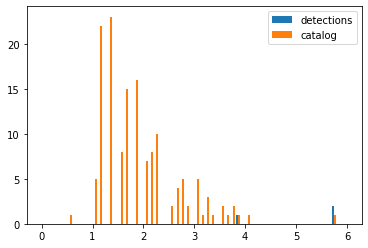

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 20-500

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=20, ltalen=500, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T07:32:19.359000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/c64d05b2-3166-4309-b3b6-6d67cc835302")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 8, 981504))
	          ---------
	      comments: 1 Elements
	         picks: 30 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/b323672b-3c5d-498f-8322-4686de62c0bc"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 639000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/38bf3af5-eb43-47cd-a44e-bc9105aec24a"), time=UTCDateTime(2019, 9, 26, 9, 0, 43, 779000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/6ea7228d-9dff-494a-a9fb-51afa3d10290"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 129000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/e7e01355-dd67-48b3-b530-e4d6a0bfd1dd"), time=UTCDateTime(2019, 9, 26, 11, 26, 46, 359000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 


In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.639000Z,
 2019-09-26T09:00:43.779000Z,
 2019-09-26T10:59:33.129000Z,
 2019-09-26T11:26:46.359000Z,
 2019-09-26T12:15:19.959000Z,
 2019-09-26T12:17:25.459000Z,
 2019-09-26T12:26:22.639000Z,
 2019-09-26T12:59:14.089000Z,
 2019-09-26T13:34:01.329000Z,
 2019-09-26T13:44:52.769000Z,
 2019-09-26T13:57:17.009000Z,
 2019-09-26T15:39:38.179000Z,
 2019-09-26T20:02:53.459000Z,
 2019-09-26T20:20:28.169000Z,
 2019-09-26T07:32:20.359000Z,
 2019-09-26T09:00:36.719000Z,
 2019-09-26T10:59:33.619000Z,
 2019-09-26T11:26:49.009000Z,
 2019-09-26T12:15:19.739000Z,
 2019-09-26T12:17:23.829000Z,
 2019-09-26T12:26:25.329000Z,
 2019-09-26T12:59:13.659000Z,
 2019-09-26T13:33:59.509000Z,
 2019-09-26T13:44:51.879000Z,
 2019-09-26T13:57:15.069000Z,
 2019-09-26T14:02:17.259000Z,
 2019-09-26T15:39:36.139000Z,
 2019-09-26T16:35:44.889000Z,
 2019-09-26T20:02:54.739000Z,
 2019-09-26T20:20:29.579000Z]

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

30

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

4

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.8999999999999999,
 5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

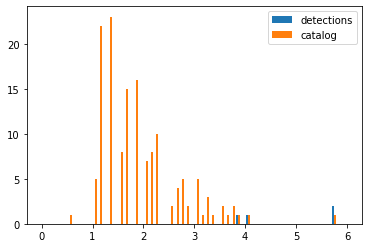

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 30-1000

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=30, ltalen=1000, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T07:32:19.379000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/4256d203-c16a-4c5d-8167-009e832e88a5")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 9, 905997))
	          ---------
	      comments: 1 Elements
	         picks: 28 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/5880238e-4235-463c-9bfc-d59b9c9ae6ac"), time=UTCDateTime(2019, 9, 26, 7, 32, 20, 869000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/1fa39826-7d79-4563-8ae4-159ea0299629"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 159000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/188719f5-9eb5-47f9-bd84-12b53a5281ef"), time=UTCDateTime(2019, 9, 26, 11, 26, 50, 849000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/3a8fb531-35e9-4b78-b78a-827c6bb5e50c"), time=UTCDateTime(2019, 9, 26, 12, 15, 20, 259000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')



In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:20.869000Z,
 2019-09-26T10:59:33.159000Z,
 2019-09-26T11:26:50.849000Z,
 2019-09-26T12:15:20.259000Z,
 2019-09-26T12:17:25.429000Z,
 2019-09-26T12:26:26.689000Z,
 2019-09-26T12:59:14.169000Z,
 2019-09-26T13:34:03.829000Z,
 2019-09-26T13:44:53.859000Z,
 2019-09-26T13:57:18.639000Z,
 2019-09-26T15:39:39.249000Z,
 2019-09-26T20:02:54.709000Z,
 2019-09-26T20:20:28.829000Z,
 2019-09-26T07:32:20.379000Z,
 2019-09-26T09:00:43.969000Z,
 2019-09-26T10:59:33.649000Z,
 2019-09-26T11:26:50.859000Z,
 2019-09-26T12:15:19.769000Z,
 2019-09-26T12:17:23.819000Z,
 2019-09-26T12:26:25.759000Z,
 2019-09-26T12:59:13.669000Z,
 2019-09-26T13:34:00.559000Z,
 2019-09-26T13:44:53.629000Z,
 2019-09-26T13:57:16.999000Z,
 2019-09-26T14:02:18.799000Z,
 2019-09-26T15:39:37.099000Z,
 2019-09-26T20:02:54.789000Z,
 2019-09-26T20:20:30.709000Z]

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

28

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

3

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998, 3.8999999999999999, 5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

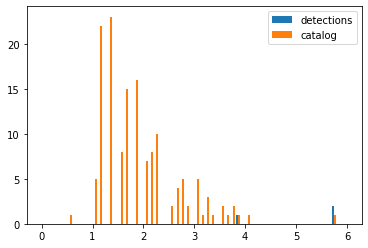

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 40-2000

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=40, ltalen=2000, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T07:32:19.389000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/9e9f1c63-b6cd-4f54-8322-ddc4b97c70c3")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 10, 743732))
	          ---------
	      comments: 1 Elements
	         picks: 26 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/520f5c53-9dd5-4e39-9e62-de0848209038"), time=UTCDateTime(2019, 9, 26, 7, 32, 21, 19000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a5d0c8f3-b90c-4944-9725-2dbdb41b146f"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 179000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/92f9be33-978b-4582-aba0-4cb3c2e45a93"), time=UTCDateTime(2019, 9, 26, 12, 15, 20, 419000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/9ccb6f08-8225-4131-9bbe-3386db46eb79"), time=UTCDateTime(2019, 9, 26, 12, 17, 25, 279000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:21.019000Z,
 2019-09-26T10:59:33.179000Z,
 2019-09-26T12:15:20.419000Z,
 2019-09-26T12:17:25.279000Z,
 2019-09-26T12:26:26.239000Z,
 2019-09-26T12:59:17.999000Z,
 2019-09-26T13:34:05.829000Z,
 2019-09-26T13:44:54.279000Z,
 2019-09-26T13:57:19.329000Z,
 2019-09-26T15:39:39.899000Z,
 2019-09-26T20:02:54.779000Z,
 2019-09-26T20:20:33.059000Z,
 2019-09-26T07:32:20.389000Z,
 2019-09-26T09:01:01.559000Z,
 2019-09-26T10:59:33.709000Z,
 2019-09-26T12:15:19.789000Z,
 2019-09-26T12:17:23.809000Z,
 2019-09-26T12:26:25.709000Z,
 2019-09-26T12:59:15.919000Z,
 2019-09-26T13:34:01.389000Z,
 2019-09-26T13:44:54.769000Z,
 2019-09-26T13:57:17.789000Z,
 2019-09-26T14:02:27.539000Z,
 2019-09-26T15:39:38.879000Z,
 2019-09-26T20:02:54.799000Z,
 2019-09-26T20:20:32.779000Z]

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

26

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

2

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z, 2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998, 5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

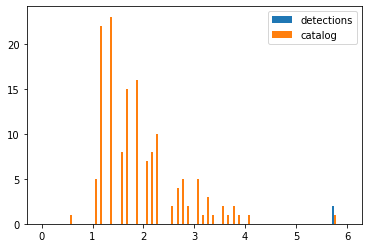

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 50-5000

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=50, ltalen=5000, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T07:32:19.399000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/29dbbf1a-5a8a-4863-b68c-c420cd398d1f")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 11, 923417))
	          ---------
	      comments: 1 Elements
	         picks: 16 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/d42f3524-55aa-4e08-8ab3-ca87398170aa"), time=UTCDateTime(2019, 9, 26, 7, 32, 21, 169000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/c86f8b52-102e-4c4c-abe8-7b33c8476668"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 189000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/72fd9c37-d768-4638-951a-de124097cd39"), time=UTCDateTime(2019, 9, 26, 12, 59, 18, 139000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/ba3c7b39-d145-49bd-aa8a-9b1fb8e6ff9f"), time=UTCDateTime(2019, 9, 26, 13, 45, 3, 619000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:21.169000Z,
 2019-09-26T10:59:33.189000Z,
 2019-09-26T12:59:18.139000Z,
 2019-09-26T13:45:03.619000Z,
 2019-09-26T13:57:21.109000Z,
 2019-09-26T15:39:41.339000Z,
 2019-09-26T20:02:54.809000Z,
 2019-09-26T20:20:32.479000Z,
 2019-09-26T07:32:20.399000Z,
 2019-09-26T10:59:33.719000Z,
 2019-09-26T12:59:16.019000Z,
 2019-09-26T13:45:25.099000Z,
 2019-09-26T13:57:18.649000Z,
 2019-09-26T15:39:39.649000Z,
 2019-09-26T20:02:54.809000Z,
 2019-09-26T20:20:32.679000Z]

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

16

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

2

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z, 2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998, 5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

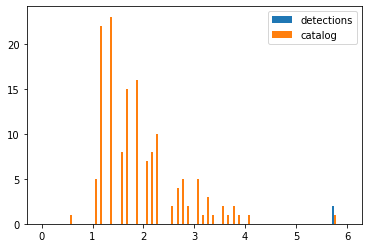

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

## Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher window-size value is changing. "window" array consists of the higher window-size, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm and compared with the catalog, do not forget, there is three seconds tolerance.**

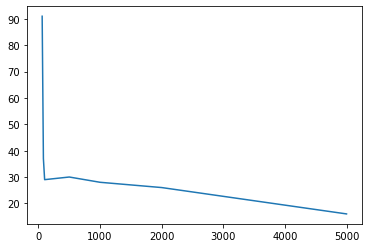

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det = np.array([91,37,29,30,28,26,16])
plt.plot(window, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

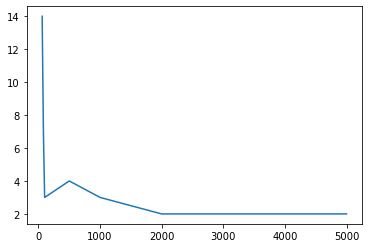

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det_cor = np.array([14,7,3,4,3,2,2])
plt.plot(window, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# With ObsPy ( Taper Apllied and Mean Removed)

## Reading the Data

In [ ]:
st= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN')
st+= obspy.read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ')

In [ ]:
st = st.copy().detrend().taper(0.4)

In [ ]:
tr1=st[0]
tr2=st[1]#obtaining traces
tr3=st[2]

# The Effect of the Window-Size

## 2-60

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(2*df),int(df*60))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(243, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
detection_times

[2019-09-26T00:00:59.998993Z,
 2019-09-26T00:02:07.538985Z,
 2019-09-26T00:02:26.948983Z,
 2019-09-26T00:02:44.888981Z,
 2019-09-26T00:02:47.778981Z,
 2019-09-26T00:03:06.148978Z,
 2019-09-26T00:03:09.588978Z,
 2019-09-26T00:03:30.148976Z,
 2019-09-26T00:03:33.558975Z,
 2019-09-26T00:03:44.848974Z,
 2019-09-26T00:03:48.658974Z,
 2019-09-26T00:03:59.638972Z,
 2019-09-26T00:04:18.058970Z,
 2019-09-26T00:04:42.638967Z,
 2019-09-26T00:05:01.188965Z,
 2019-09-26T00:05:07.868964Z,
 2019-09-26T00:05:11.098964Z,
 2019-09-26T00:05:19.198963Z,
 2019-09-26T00:05:37.858961Z,
 2019-09-26T00:05:45.788960Z,
 2019-09-26T00:05:49.378960Z,
 2019-09-26T00:06:01.968958Z,
 2019-09-26T00:06:05.528958Z,
 2019-09-26T00:06:40.598954Z,
 2019-09-26T00:06:49.298953Z,
 2019-09-26T00:07:47.258946Z,
 2019-09-26T00:07:50.558946Z,
 2019-09-26T00:08:51.618938Z,
 2019-09-26T00:08:55.358938Z,
 2019-09-26T00:08:58.948938Z,
 2019-09-26T00:11:24.788921Z,
 2019-09-26T00:11:39.308919Z,
 2019-09-26T00:11:46.578918Z,
 2019-09-2

In [ ]:
num_detect_tim=len(detection_times)
num_detect_tim
#the number of detections by the algorithm

243

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

18

In [ ]:
correct_det_times
#the dates of correct earthquakes.

[2019-09-26T07:32:14.677000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T14:07:59.316000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T21:23:53.417000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 2.8999999999999999,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 2.6000000000000001,
 3.0,
 2.2999999999999998,
 1.8999999999999999,
 2.2000000000000002,
 3.5,
 1.7,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

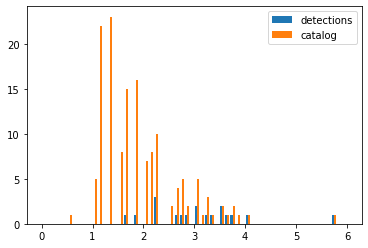

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 10-80

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(10*df),int(df*80))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(35, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

10

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

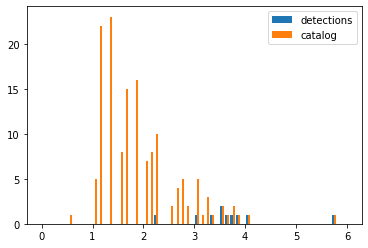

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 20-100

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(20*df),int(df*100))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(26, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

7

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

<function matplotlib.pyplot.show(*args, **kw)>

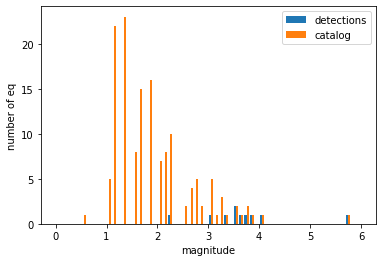

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.xlabel('magnitude')
plt.ylabel('number of eq')
plt.legend()
plt.show

# 20-500

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(20*df),int(df*500))
#Value above which trigger (of characteristic function) is activated (higher threshold); first one
#Value below which trigger (of characteristic function) is deactivated (lower threshold); second one
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(29, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

5

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[3.6000000000000001, 5.7999999999999998, 3.0, 3.5, 3.8999999999999999]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

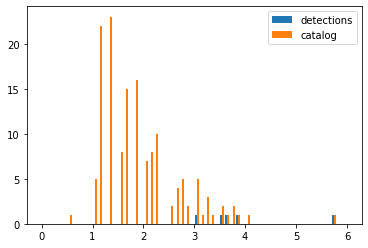

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 30-1000

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(30*df),int(df*1000))
on_of = trigger_onset(cft, 2.75,1.75)

In [ ]:
on_of.shape

(13, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

2

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z, 2019-09-26T20:02:48.710000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 3.5]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

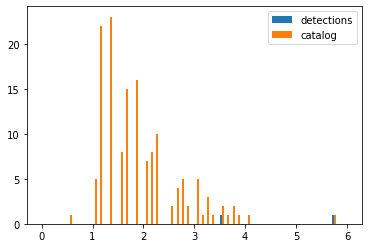

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 40-2000

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(40*df),int(df*2000))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(6, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

2

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z, 2019-09-26T20:02:48.710000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[5.7999999999999998, 3.5]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

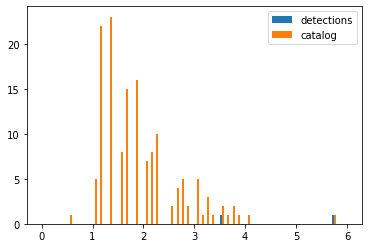

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 50-5000

In [ ]:
df = tr1.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr1.data, int(50*df),int(df*5000))
on_of = trigger_onset(cft, 2.75, 1.75)

In [ ]:
on_of.shape

(5, 2)

In [ ]:
onof=on_of.shape[0]

In [ ]:
#the start times for the earthquake
detection_times=[]
for i in np.arange(0, onof):
    time=tr1.stats.starttime + on_of[i,0]*86400.08/8640009
    detection_times.append(time)

In [ ]:
num_detect_tim=len(detection_times)

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detection_times[time_index] and utc_time26[cat_event_index]+3 >= detection_times[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

2

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z, 2019-09-26T10:59:32.667000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag

[3.6000000000000001, 5.7999999999999998]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

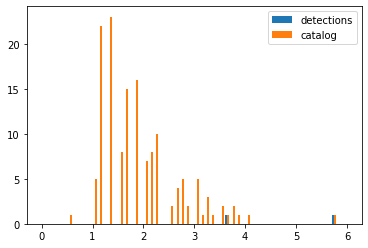

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

## Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher window-size value is changing. "window" array consists of the higher window-size, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm and compared with the catalog, do not forget, there is three seconds tolerance.**

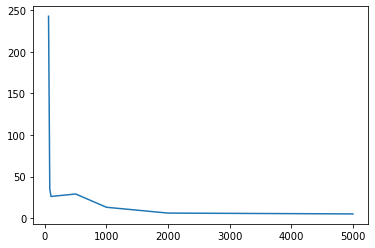

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det = np.array([243,35,26,29,13,6,5])
plt.plot(window, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

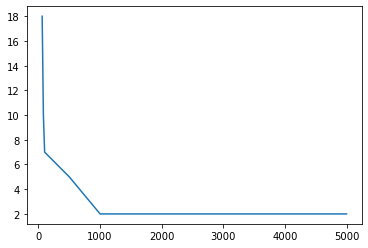

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det_cor = np.array([18,10,7,5,2,2,2])
plt.plot(window, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# APPENDIX 4 : With EqCorrscan (Taper Applied and Mean Removed)

## Reading the Data

In [ ]:
st=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHE', format="SAC")
st+=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHZ', format="SAC")
st+=read('/Users/korayaydogan/Downloads/SLVT/2019-0926000000_SLVT.HHN',format="SAC")

In [ ]:
st.merge(method=0,fill_value='interpolate', interpolation_samples=1)

3 Trace(s) in Stream:
KO.SLVT..HHE | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples
KO.SLVT..HHN | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples
KO.SLVT..HHZ | 2019-09-25T23:59:59.999000Z - 2019-09-27T00:00:00.079000Z | 100.0 Hz, 8640009 samples

In [ ]:
st = st.copy().detrend().taper(0.05)

In [ ]:
tr1=st[0]
tr2=st[1]#obtaining traces
tr3=st[2]

# The Effect of the Window-size

## 2-60

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=2, ltalen=60, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:00:58.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/a6a06fff-fb87-4407-93a1-83a03f3629e3")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 21, 366682))
	          ---------
	      comments: 1 Elements
	         picks: 2318 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/19e64a05-d54a-4840-bf8f-2e7128e72ed3"), time=UTCDateTime(2019, 9, 26, 0, 0, 59, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/b8625d34-8431-4d32-9a77-936370e0252b"), time=UTCDateTime(2019, 9, 26, 0, 1, 2, 129000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/7fd2c95a-23c0-4c85-917f-4b74da9f26e6"), time=UTCDateTime(2019, 9, 26, 0, 1, 6, 259000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/aad832d3-a185-4f16-a9d5-08ea36afb4c2"), time=UTCDateTime(2019, 9, 26, 0, 1, 10, 609000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(r

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:00:59.989000Z,
 2019-09-26T00:01:02.129000Z,
 2019-09-26T00:01:06.259000Z,
 2019-09-26T00:01:10.609000Z,
 2019-09-26T00:01:14.289000Z,
 2019-09-26T00:01:18.139000Z,
 2019-09-26T00:01:21.909000Z,
 2019-09-26T00:01:29.229000Z,
 2019-09-26T00:01:32.699000Z,
 2019-09-26T00:01:36.379000Z,
 2019-09-26T00:01:40.219000Z,
 2019-09-26T00:01:46.679000Z,
 2019-09-26T00:01:50.429000Z,
 2019-09-26T00:01:54.389000Z,
 2019-09-26T00:01:58.619000Z,
 2019-09-26T00:02:08.099000Z,
 2019-09-26T00:02:12.489000Z,
 2019-09-26T00:02:15.739000Z,
 2019-09-26T00:02:20.159000Z,
 2019-09-26T00:02:23.569000Z,
 2019-09-26T00:02:27.299000Z,
 2019-09-26T00:02:30.859000Z,
 2019-09-26T00:02:34.839000Z,
 2019-09-26T00:02:38.359000Z,
 2019-09-26T00:02:42.259000Z,
 2019-09-26T00:02:48.179000Z,
 2019-09-26T00:02:51.079000Z,
 2019-09-26T00:03:06.579000Z,
 2019-09-26T00:03:09.919000Z,
 2019-09-26T00:03:13.559000Z,
 2019-09-26T00:03:30.379000Z,
 2019-09-26T00:03:34.039000Z,
 2019-09-26T00:03:45.219000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

2318

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

76

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T09:00:24.380000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:13:31.340000Z,
 2019-09-26T11:19:07.248000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:33:51.797000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T13:57:08.750000Z,
 2019-09-26T14:02:04.180000Z,
 2019-09-26T14:07:59.316000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T15:52:27.570000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T17:03:39.480000Z,
 2019-09-26T18:06:30.840000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-26T18:26:51.836000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:15:29.406000Z,
 2019-09-26T20:15:29.406000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T20:26:29.946000Z,
 2019-09-26T20:36:29.982000Z,
 2019-09-26T21:01:03.886000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 2.8999999999999999,
 5.7999999999999998,
 2.2999999999999998,
 1.8999999999999999,
 2.8999999999999999,
 4.0999999999999996,
 3.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 2.7000000000000002,
 2.6000000000000001,
 3.0,
 1.8,
 2.2999999999999998,
 1.8999999999999999,
 1.8,
 1.2,
 2.0,
 1.8,
 2.2000000000000002,
 3.5,
 2.0,
 2.0,
 3.8999999999999999,
 1.2,
 1.3,
 1.1000000000000001,
 1.8,
 1.1000000000000001,
 1.8,
 1.7,
 1.7,
 2.1000000000000001,
 1.3999999999999999,
 2.2000000000000002,
 1.3999999999999999,
 2.2000000000000002,
 3.6000000000000001,
 2.8999999999999999,
 5.7999999999999998,
 2.8999999999999999,
 4.0999999999999996,
 3.2000000000000002,
 2.0,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.0,
 2.7999999999999998,
 3.2000000000000002,
 2.7000000000000002,
 2.6000000000000001,
 1.7,
 1.5,
 3.0,
 1.8,
 1.8,
 1.8,
 1.3999999999999999,
 1.3999999

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

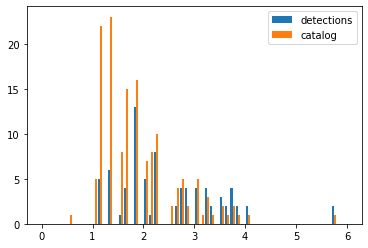

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 10-80

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=10, ltalen=80, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:01:18.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/d9a87458-ead2-465b-88ba-f7f1eb3486ec")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 42, 154436))
	          ---------
	      comments: 1 Elements
	         picks: 247 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/52211b04-09aa-45b2-88b2-bd973245fe0d"), time=UTCDateTime(2019, 9, 26, 0, 1, 19, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/4f0c3e01-a80b-4650-83ef-472a108991eb"), time=UTCDateTime(2019, 9, 26, 0, 44, 11, 969000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/37bf3fc9-581c-47df-984f-a1cb2da66078"), time=UTCDateTime(2019, 9, 26, 7, 32, 16, 559000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/40c1b246-0161-49ed-9653-3f6709b8a248"), time=UTCDateTime(2019, 9, 26, 9, 0, 30, 329000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pi

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:01:19.989000Z,
 2019-09-26T00:44:11.969000Z,
 2019-09-26T07:32:16.559000Z,
 2019-09-26T09:00:30.329000Z,
 2019-09-26T10:59:33.019000Z,
 2019-09-26T11:20:08.859000Z,
 2019-09-26T11:26:45.159000Z,
 2019-09-26T11:32:06.129000Z,
 2019-09-26T11:34:16.719000Z,
 2019-09-26T11:43:13.299000Z,
 2019-09-26T11:51:42.509000Z,
 2019-09-26T12:00:46.579000Z,
 2019-09-26T12:04:06.179000Z,
 2019-09-26T12:04:36.379000Z,
 2019-09-26T12:15:14.439000Z,
 2019-09-26T12:17:21.089000Z,
 2019-09-26T12:23:02.829000Z,
 2019-09-26T12:26:19.579000Z,
 2019-09-26T12:34:32.719000Z,
 2019-09-26T12:52:33.539000Z,
 2019-09-26T12:59:09.999000Z,
 2019-09-26T13:33:56.779000Z,
 2019-09-26T13:44:48.469000Z,
 2019-09-26T13:57:11.869000Z,
 2019-09-26T14:02:09.719000Z,
 2019-09-26T14:08:04.719000Z,
 2019-09-26T14:10:54.289000Z,
 2019-09-26T15:39:30.549000Z,
 2019-09-26T16:35:39.319000Z,
 2019-09-26T17:03:47.789000Z,
 2019-09-26T17:59:10.559000Z,
 2019-09-26T18:03:08.419000Z,
 2019-09-26T18:21:06.059000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

247

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

47

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:20:02.740000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T11:34:11.070000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:17:17.397000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T13:44:45.476000Z,
 2019-09-2

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 1.8999999999999999,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 3.6000000000000001,
 5.7999999999999998,
 2.8999999999999999,
 4.0999999999999996,
 3.2000000000000002,
 3.3999999999999999,
 3.7000000000000002,
 3.7000000000000002,
 3.5,
 2.7999999999999998,
 3.2000000000000002,
 3.0,
 2.2999999999999998,
 1.8999999999999999,
 1.8999999999999999,
 1.2,
 2.0,
 1.8,
 2.2000000000000002,
 2.0,
 3.5,
 3.8999999999999999,
 2.1000000000000001,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

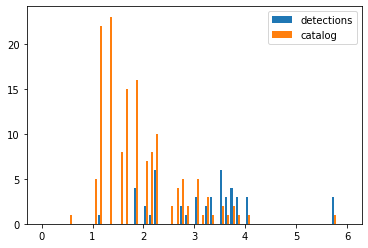

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

# 20-100

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=20, ltalen=100, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:01:38.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/24c20516-d6be-4247-bffb-f21c1dd9ebd5")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 44, 832129))
	          ---------
	      comments: 1 Elements
	         picks: 125 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/3e6a1eb8-fde0-45f9-a531-7d9df59802a4"), time=UTCDateTime(2019, 9, 26, 0, 1, 39, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/bbf8d18c-ec46-4e9f-9257-7030608fc278"), time=UTCDateTime(2019, 9, 26, 7, 32, 19, 609000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/352f84d6-9145-4b57-a4d8-0ecf96c8ba72"), time=UTCDateTime(2019, 9, 26, 9, 0, 31, 309000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/9af4d85e-511f-4ddc-bc73-b1be0915cfd7"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 49000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pi

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:01:39.989000Z,
 2019-09-26T07:32:19.609000Z,
 2019-09-26T09:00:31.309000Z,
 2019-09-26T10:59:33.049000Z,
 2019-09-26T11:20:10.259000Z,
 2019-09-26T11:26:45.389000Z,
 2019-09-26T11:32:09.049000Z,
 2019-09-26T11:34:17.179000Z,
 2019-09-26T12:15:15.569000Z,
 2019-09-26T12:17:24.469000Z,
 2019-09-26T12:26:19.769000Z,
 2019-09-26T12:34:36.169000Z,
 2019-09-26T12:59:13.459000Z,
 2019-09-26T13:33:57.519000Z,
 2019-09-26T13:44:51.379000Z,
 2019-09-26T13:57:14.739000Z,
 2019-09-26T14:02:10.079000Z,
 2019-09-26T14:08:05.849000Z,
 2019-09-26T15:39:31.689000Z,
 2019-09-26T16:35:39.619000Z,
 2019-09-26T17:03:58.379000Z,
 2019-09-26T18:21:06.709000Z,
 2019-09-26T19:10:14.309000Z,
 2019-09-26T19:20:13.979000Z,
 2019-09-26T19:44:07.229000Z,
 2019-09-26T20:02:48.849000Z,
 2019-09-26T20:20:26.999000Z,
 2019-09-26T20:31:13.779000Z,
 2019-09-26T21:42:36.759000Z,
 2019-09-26T21:46:08.589000Z,
 2019-09-26T21:49:16.869000Z,
 2019-09-26T22:02:26.539000Z,
 2019-09-26T23:03:54.839000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

125

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

28

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T23:48:14.266000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T16:35:33.300000Z,
 2019-09-26T16:49:27.770000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 2.2000000000000002,
 5.7999999999999998,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.0,
 2.2999999999999998,
 1.8999999999999999,
 2.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

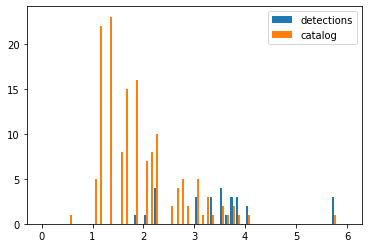

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 20-500

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=20, ltalen=500, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:08:18.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/4b103291-ba21-4f9a-aa97-6ceae79445c2")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 46, 57850))
	          ---------
	      comments: 1 Elements
	         picks: 119 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/3a7eec8b-e169-490e-b034-aa27413d0015"), time=UTCDateTime(2019, 9, 26, 0, 8, 19, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/ffedeb83-d396-47b4-a862-bed810738a6b"), time=UTCDateTime(2019, 9, 26, 0, 17, 32, 609000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/37da4097-6558-48ea-84a5-4078dfea9fd3"), time=UTCDateTime(2019, 9, 26, 0, 19, 12, 539000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/712d5847-dccb-4a90-8f90-52c2e9a9966b"), time=UTCDateTime(2019, 9, 26, 0, 44, 13, 299000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

P

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:08:19.989000Z,
 2019-09-26T00:17:32.609000Z,
 2019-09-26T00:19:12.539000Z,
 2019-09-26T00:44:13.299000Z,
 2019-09-26T07:32:17.009000Z,
 2019-09-26T09:00:30.419000Z,
 2019-09-26T10:59:33.029000Z,
 2019-09-26T11:20:27.289000Z,
 2019-09-26T11:26:45.549000Z,
 2019-09-26T11:43:15.629000Z,
 2019-09-26T11:51:45.789000Z,
 2019-09-26T12:00:52.799000Z,
 2019-09-26T12:04:36.579000Z,
 2019-09-26T12:15:14.449000Z,
 2019-09-26T12:17:24.849000Z,
 2019-09-26T12:26:20.579000Z,
 2019-09-26T12:59:10.419000Z,
 2019-09-26T13:33:57.469000Z,
 2019-09-26T13:44:49.699000Z,
 2019-09-26T13:57:12.589000Z,
 2019-09-26T14:02:15.549000Z,
 2019-09-26T14:08:07.479000Z,
 2019-09-26T15:39:31.399000Z,
 2019-09-26T16:35:39.349000Z,
 2019-09-26T16:49:41.429000Z,
 2019-09-26T17:03:51.329000Z,
 2019-09-26T17:59:13.959000Z,
 2019-09-26T18:03:12.219000Z,
 2019-09-26T18:21:06.079000Z,
 2019-09-26T19:10:13.209000Z,
 2019-09-26T19:20:11.779000Z,
 2019-09-26T19:44:06.809000Z,
 2019-09-26T20:02:48.829000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

119

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

18

In [ ]:
correct_det_times

[2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.5,
 3.0,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

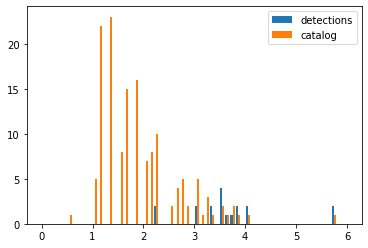

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 30-1000

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=30, ltalen=1000, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:16:38.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/83f41116-ee4c-4cb6-b29a-23db14e203be")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 47, 393987))
	          ---------
	      comments: 1 Elements
	         picks: 140 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/cf1564cf-99a4-4013-a882-7896685359c9"), time=UTCDateTime(2019, 9, 26, 0, 16, 39, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/e3f4cdc5-d42b-4959-91bf-aef9a9cb15f9"), time=UTCDateTime(2019, 9, 26, 0, 34, 11, 589000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/c35f70b0-4660-493d-9cf4-6cf64de9b084"), time=UTCDateTime(2019, 9, 26, 0, 42, 5, 789000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/7b5faf64-a40c-475e-bf9d-1b4226f39708"), time=UTCDateTime(2019, 9, 26, 0, 44, 8, 699000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pi

In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:16:39.989000Z,
 2019-09-26T00:34:11.589000Z,
 2019-09-26T00:42:05.789000Z,
 2019-09-26T00:44:08.699000Z,
 2019-09-26T07:32:17.909000Z,
 2019-09-26T09:00:30.619000Z,
 2019-09-26T10:59:33.049000Z,
 2019-09-26T11:26:50.519000Z,
 2019-09-26T12:04:38.239000Z,
 2019-09-26T12:15:15.309000Z,
 2019-09-26T12:17:24.239000Z,
 2019-09-26T12:26:26.369000Z,
 2019-09-26T12:59:11.839000Z,
 2019-09-26T13:33:57.509000Z,
 2019-09-26T13:44:51.749000Z,
 2019-09-26T13:57:15.929000Z,
 2019-09-26T14:02:14.079000Z,
 2019-09-26T15:39:31.719000Z,
 2019-09-26T16:35:39.549000Z,
 2019-09-26T17:04:04.469000Z,
 2019-09-26T18:21:06.109000Z,
 2019-09-26T19:10:13.509000Z,
 2019-09-26T19:20:14.129000Z,
 2019-09-26T20:02:48.869000Z,
 2019-09-26T20:20:27.399000Z,
 2019-09-26T21:24:16.359000Z,
 2019-09-26T21:42:35.669000Z,
 2019-09-26T21:46:08.609000Z,
 2019-09-26T21:49:16.879000Z,
 2019-09-26T22:02:32.309000Z,
 2019-09-26T22:35:20.819000Z,
 2019-09-26T23:03:49.749000Z,
 2019-09-26T23:48:22.459000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

140

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

22

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T11:26:44.530000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T12:26:19.020000Z,
 2019-09-26T12:59:07.946000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T18:21:00.207000Z,
 2019-09-26T19:10:07.146000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 3.3999999999999999,
 3.0,
 3.5,
 3.8999999999999999,
 5.7999999999999998,
 3.3999999999999999,
 3.0,
 3.5,
 3.8999999999999999,
 3.6000000000000001,
 5.7999999999999998,
 4.0999999999999996,
 3.3999999999999999,
 3.7000000000000002,
 3.5,
 3.0,
 2.0,
 2.2000000000000002,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

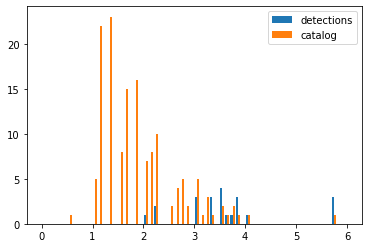

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 40-2000

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=40, ltalen=2000, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T00:33:18.989000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/45b4c86e-522a-4675-ba5e-c015536d001d")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 48, 563892))
	          ---------
	      comments: 1 Elements
	         picks: 61 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/319ea6b4-3933-4366-bb90-88cf691e230f"), time=UTCDateTime(2019, 9, 26, 0, 33, 19, 989000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/f7575f11-2b82-4ddf-9274-30fcb8ee1f9a"), time=UTCDateTime(2019, 9, 26, 0, 49, 39, 369000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/3711f2d3-4a7b-4abc-ba0b-fe30f437cc29"), time=UTCDateTime(2019, 9, 26, 0, 54, 59, 669000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/a7112fac-25af-4c60-a6b4-3d6a9e53169e"), time=UTCDateTime(2019, 9, 26, 7, 32, 18, 759000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 



In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T00:33:19.989000Z,
 2019-09-26T00:49:39.369000Z,
 2019-09-26T00:54:59.669000Z,
 2019-09-26T07:32:18.759000Z,
 2019-09-26T09:00:31.129000Z,
 2019-09-26T10:59:33.049000Z,
 2019-09-26T12:15:15.669000Z,
 2019-09-26T12:17:23.849000Z,
 2019-09-26T12:26:25.919000Z,
 2019-09-26T12:59:17.349000Z,
 2019-09-26T13:33:57.519000Z,
 2019-09-26T13:44:51.589000Z,
 2019-09-26T13:57:15.889000Z,
 2019-09-26T14:02:16.869000Z,
 2019-09-26T15:39:32.929000Z,
 2019-09-26T16:35:39.649000Z,
 2019-09-26T18:21:06.389000Z,
 2019-09-26T19:10:14.499000Z,
 2019-09-26T19:20:14.359000Z,
 2019-09-26T20:02:48.969000Z,
 2019-09-26T20:20:32.779000Z,
 2019-09-26T21:42:37.389000Z,
 2019-09-26T21:46:09.029000Z,
 2019-09-26T21:49:16.879000Z,
 2019-09-26T22:02:31.519000Z,
 2019-09-26T23:03:53.599000Z,
 2019-09-26T00:33:19.989000Z,
 2019-09-26T00:47:51.199000Z,
 2019-09-26T00:49:30.099000Z,
 2019-09-26T00:50:50.089000Z,
 2019-09-26T00:52:33.069000Z,
 2019-09-26T00:55:41.359000Z,
 2019-09-26T06:03:54.179000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

61

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

7

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T12:15:13.618000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 3.3999999999999999,
 3.5,
 5.7999999999999998,
 3.3999999999999999,
 3.0,
 3.5]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

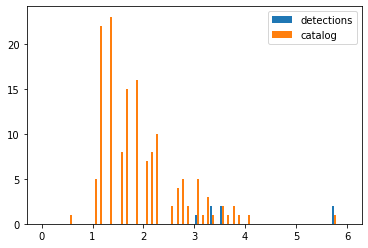

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()
plt.show()

# 50-5000

In [ ]:
events=eqcorrscan.utils.picker.stalta_pick(st,  stalen=50, ltalen=5000, trig_on=2.75, trig_off=1.75)
events

Event:	2019-09-26T04:14:29.369000Z | None, None

	   resource_id: ResourceIdentifier(id="smi:local/2012d2dc-9471-4b04-b949-04b565f72169")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2020, 8, 26, 10, 7, 49, 669844))
	          ---------
	      comments: 1 Elements
	         picks: 75 Elements
	       origins: 1 Elements

In [ ]:
for i in range(len(events)):
    pprint(events.picks[i])
    print("\n \n")

Pick(resource_id=ResourceIdentifier(id="smi:local/19ffb331-e4d0-4916-a590-05c467091006"), time=UTCDateTime(2019, 9, 26, 7, 32, 18, 919000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/dfba6a09-37cb-4c3e-986d-0219626195d6"), time=UTCDateTime(2019, 9, 26, 9, 0, 31, 249000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/9bb7407d-a363-4d68-9a74-ecfd6dd88ea6"), time=UTCDateTime(2019, 9, 26, 10, 59, 33, 59000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 

Pick(resource_id=ResourceIdentifier(id="smi:local/957c55b8-c8eb-40dc-bd23-e043b72f807a"), time=UTCDateTime(2019, 9, 26, 12, 59, 17, 289000), waveform_id=WaveformStreamID(network_code='KO', station_code='SLVT', channel_code='HHE'), phase_hint='S')

 



In [ ]:
detect_timlst=[]
for i in range(len(events.picks)):
    detect_timlst.append(obspy.UTCDateTime(events.picks[i].time))
detect_timlst

[2019-09-26T07:32:18.919000Z,
 2019-09-26T09:00:31.249000Z,
 2019-09-26T10:59:33.059000Z,
 2019-09-26T12:59:17.289000Z,
 2019-09-26T13:44:56.279000Z,
 2019-09-26T13:57:16.919000Z,
 2019-09-26T14:02:18.839000Z,
 2019-09-26T15:39:34.869000Z,
 2019-09-26T16:35:41.789000Z,
 2019-09-26T18:21:06.849000Z,
 2019-09-26T19:10:17.079000Z,
 2019-09-26T19:20:19.719000Z,
 2019-09-26T20:02:49.069000Z,
 2019-09-26T20:20:29.959000Z,
 2019-09-26T21:46:33.579000Z,
 2019-09-26T21:49:16.889000Z,
 2019-09-26T22:02:28.509000Z,
 2019-09-26T23:04:05.229000Z,
 2019-09-26T06:03:59.239000Z,
 2019-09-26T07:32:19.499000Z,
 2019-09-26T09:00:30.299000Z,
 2019-09-26T10:52:18.969000Z,
 2019-09-26T10:59:33.089000Z,
 2019-09-26T12:59:13.929000Z,
 2019-09-26T13:34:26.179000Z,
 2019-09-26T13:44:57.389000Z,
 2019-09-26T13:57:15.589000Z,
 2019-09-26T14:02:13.869000Z,
 2019-09-26T15:39:31.449000Z,
 2019-09-26T16:35:39.799000Z,
 2019-09-26T17:04:09.659000Z,
 2019-09-26T17:59:06.779000Z,
 2019-09-26T18:03:09.289000Z,
 2019-09-2

In [ ]:
detect_tim = np.asarray(detect_timlst)
num_detect_tim = detect_tim.shape[0]
num_detect_tim

75

In [ ]:
count=0
correct_det_times=[]
for time_index in range(num_detect_tim-1):
    for cat_event_index in range(cat_time26-1):
        if utc_time26[cat_event_index]-3 <= detect_tim[time_index] and utc_time26[cat_event_index]+3 >= detect_tim[time_index]:
            count+=1
            correct_det_times.append(utc_time26[cat_event_index])

In [ ]:
count

11

In [ ]:
correct_det_times

[2019-09-26T10:59:32.667000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T22:02:25.806000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T15:39:29.707000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T07:32:14.677000Z,
 2019-09-26T10:59:32.667000Z,
 2019-09-26T20:02:48.710000Z,
 2019-09-26T20:20:26.716000Z,
 2019-09-26T22:02:25.806000Z]

In [ ]:
correct_det_mag=[]
for det_time in range(len(correct_det_times)):
    for event_time in range(len(utc_time26)):
        if correct_det_times[det_time]==utc_time26[event_time]:
            correct_det_mag.append(magnitudes26[event_time])

In [ ]:
correct_det_mag
#magnitudes

[5.7999999999999998,
 3.5,
 2.2000000000000002,
 5.7999999999999998,
 3.0,
 3.5,
 3.6000000000000001,
 5.7999999999999998,
 3.5,
 3.8999999999999999,
 2.2000000000000002]

In [ ]:
bins = np.arange(0,6.1,0.1)
ylim = np.arange(1,20,1)
detections = correct_det_mag
catalog = magnitudes26

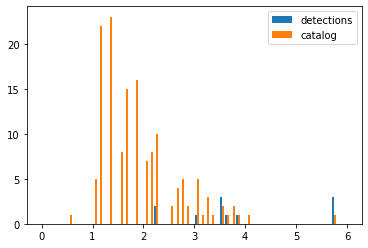

In [ ]:
plt.hist([detections, catalog], bins, label = ["detections","catalog"])
plt.legend()

## Overall Graphs

- **The fallowing plots shows us: the change in the number of detections, while the higher threshold value is changing. "window" array consists of the window-size values, "num_det" array consists of the number of earthquakes detected by the algorithm, but not compared with the catalog. "num_det_cor" array consists of the number of the earthquakes which are detected by the algorithm**

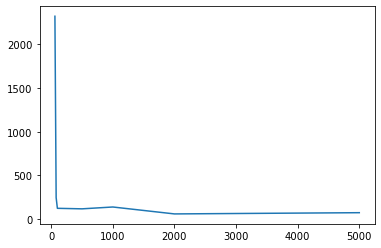

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det = np.array([2318,247,125,119,140,61,75])
plt.plot(window, num_det)
plt.show()
#the number of the detection that are found by lta sta plots

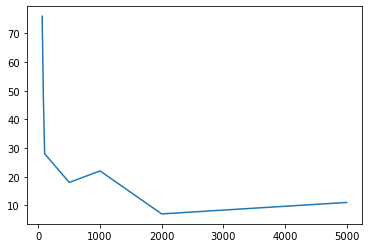

In [ ]:
window = np.array([60,80,100,500,1000,2000,5000])
num_det_cor = np.array([76,47,28,18,22,7,11])
plt.plot(window, num_det_cor)
plt.show()
#the number of the correct detection plots (tolerance is 3 seconds)

# Appendix / Brief Summary / Inferences

- **Since the notebook is too long, let us give you some inferences about these models:**
   - **As the threshold value increases the number of detection is decreased especially the model loses its efficiency on the weak earthquakes, but as you read the biggest earthquake is detected though.**
   - **Again, as the window-size value increases the number of detection is again decreased. We can assimilate it as threshold effect. But, as you saw, the big earthquake(5.8) is always detected.**
   - **Eqcorrscan package maybe is better than ObsPy since the source code of the Eqcorrscan showed us that it makes some elimination on the detections. But, again we want to say that Eqcorrscan module gives us the detection times twice. It is bad for us but, the detections, that are found by Eqcorrscan, make more sense than ObsPy.**
   - **Tapering and removing mean is beneficial for us, since they prevent deconvolution. And, this circumstance makes the model better. Also, once we use taper and remove the mean, the number of detection is increased. But, as you saw the best model worked on Eqcorrscan(mean removed & taper applied).**



- **Also we wanted to share with you another parameters and their effects on the model:**
    - **Window-sizes: 2-60, thresholds: 10-4, number of detection: 12, max_magnitude: 5.8 , min_magnitude:2.2**
    - **Window-sizes: 2-30, thresholds: 10-4, number of detection: 0, max_magnitude: none , min_magnitude:none**
    - **Window-sizes: 2-30, thresholds: 12-4, number of detection: 0, max_magnitude: none , min_magnitude:none**
    - **Window-sizes: 2-30, thresholds: 8-4, number of detection: 4, max_magnitude: 3.7 , min_magnitude:3**
    - **Window-sizes: 2-30, thresholds: 8-5, number of detection: 4, max_magnitude: 3.7 , min_magnitude:3**
    - **Window-sizes: 2-30, thresholds: 8-6, number of detection: 4, max_magnitude: 3.7 , min_magnitude:3**
    - **Window-sizes: 2-30, thresholds: 10-6, number of detection: 0, max_magnitude: 3.7 , min_magnitude:3**

- **Also, we wanted to say the best two parameters and package name: (you can view them on the Eqcoorscan and tapered section)**
    - **Window-sizes: 2-60, thresholds: 2-0.5, package name: Eqcorrscan(Attempt)**
    - **Window-sizes: 2-60, thresholds: 2.75-1.75, package name: Eqcorrscan(Attempt)**
    - **Window-sizes: 2-60, thresholds: 2.75-1.75, package name: ObsPy**